# Predcition of Hospital Admission Related to Lower Respiratory Tract Infection

In this notebook, we develop Cox proportional hazard regression models to predict the risk of hospital admission related to lower respiratory tract infection (LRTI). We, then, analyse whether prescribing antibiotics is based on the risk of hospital admission or not by building logistic regression (LR) and random forest (RF) models.

In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit
from datetime import date
from operator import attrgetter
import io
from contextlib import redirect_stdout
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

## 0- functions

In [2]:
#function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [3]:
#round counts in a way that the last digit become 0 or 5
def round_five_mul(x, base=5):
    return base * round(x/base)

In [4]:
#function to process infection data 
def proc_infec_data(data, i):
    datum = data
    datum = datum[['age', 'age_cat', 'sex', 'flu_vaccine', 'smoking', 'bmi', 'imd', 'ethnicity', 
                   'region', 'CCI', 'died_date', 'deregistered_date', 'practice', 
                   'antibacterial_brit_'+str(i), 'lrti_date_'+str(i), 'lrti_ab_date_'+str(i), 'lrti_ab_type_'+str(i),
                   'incdt_lrti_date_'+str(i), 'admitted_lrti_date_'+str(i), 'sgss_gp_cov_lrti_date_'+str(i)]]
    
    #drop rows with no lrti reord
    datum = datum[datum['lrti_date_'+str(i)].notnull()]
    #exclusion of covid positive 90 days before and 30 days after dx with lrti_i
    datum = datum[datum['sgss_gp_cov_lrti_date_'+str(i)] == 0]
    #rename variables with i
    datum.rename(columns={'lrti_date_'+str(i): 'lrti_date', 'lrti_ab_date_'+str(i): 'lrti_ab_date', 
                           'lrti_ab_type_'+str(i): 'ab_type', 'antibacterial_brit_'+str(i): 'antibacterial_brit',
                           'incdt_lrti_date_'+str(i): 'incdt_lrti_date', 'incdt_lrti_type_'+str(i): 'incdt_lrti_type',
                           'admitted_lrti_date_'+str(i): 'admitted_lrti_date',
                           'sgss_gp_cov_lrti_date_'+str(i): 'sgss_gp_cov_lrti_date'},
                inplace=True)
    
    return datum

In [5]:
#summary table of baseline characteristics
def make_summary_table(infection, infection_type, prob_pred):

    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'period']].columns)
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_tot = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit']]], axis=1)

    #calculate sums
    summary_table = prob_pred_enc_tot.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_tot.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_tot.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_'+infection+'_'+infection_type+'.csv', index=False)

In [6]:
#summary table of baseline characteristics
def make_summary_table_deciles(infection, infection_type, prob_pred_enc_lr_rf):
    #calculate sums
    summary_table = prob_pred_enc_lr_rf.sum(axis=0).reset_index()
    summary_table.columns = ['variable', 'count']
    #round count to make last digit either 0 or 5
    summary_table['mean'] = prob_pred_enc_lr_rf.mean(axis=0).reset_index()[0]
    summary_table['count'] = round_five_mul(summary_table['count'], base=5)
    summary_table['std'] = prob_pred_enc_lr_rf.std(axis=0).reset_index()[0]
    #replace small counts (<=5) with 'SM'
    summary_table.loc[(summary_table['count'] <= 5), 'count'] = 'SM'

    #save table
    summary_table.to_csv('../output/hospitalisation_prediction_'+infection+'/summary_table_deciles_'+infection+'_'+infection_type+'.csv', index=False)

In [7]:
def cox_build(infection, infection_type, data, data_no_abs): #data_lrti_incdt, data_lrti_no_abs_incdt
    #randomly splitting data into training (%75) and testing (%25)
    data_dev, data_val = train_test_split(data_no_abs, test_size=0.25, random_state=42)

    cph = CoxPHFitter()
    cph.fit(data_dev,
            duration_col='duration_lrti_admitted',
            event_col='event_lrti_admitted',
            formula="age_cat + sex + CCI_cat + flu_vaccine + region + imd + ethnicity + smoking + season + bmi_cat + antibacterial_brit")
    cph.print_summary()

    #save model output
    output = GetPrintSummary(cph)
    with open('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_summary.html', "w") as fo:
        print(fo.write(output))
        fo.close()

    #save hazard ratios
    covariates_betas = cph.hazard_ratios_.reset_index()
    confidence_intervals = cph.confidence_intervals_.reset_index()
    hrs = covariates_betas.merge(confidence_intervals, on='covariate', how='left')
    hrs['95% lower-bound'] = np.exp(hrs['95% lower-bound'])
    hrs['95% upper-bound'] = np.exp(hrs['95% upper-bound'])
    hrs.covariate = hrs.covariate.str.replace("[","")
    hrs.covariate = hrs.covariate.str.replace("]","")
    hrs.covariate = hrs.covariate.str.replace("T.","_")
    hrs.to_csv('../output/hospitalisation_prediction_'+infection+'/cph_'+infection+'_'+infection_type+'_hrs.csv', index=False)

    ##add deciles of predicted risks and probability of prescribed antibiotics
    #predict cumulative hazard in day 30 in train dataset
    prob_pred = cph.predict_cumulative_hazard(data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit']]).loc[[30]].T
    prob_pred.columns = ['pred']
    #prob_pred_lrti_no_abs_incdt

    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    prob_pred['bins'] = pd.qcut(prob_pred['pred'], 10)
    #prob_pred

    ##add a column for prescribed antibiotics
    prob_pred = pd.concat([prob_pred, data[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 'antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred

    ###needed for figures
    #groupby bins to find mean predicted probability for each bin (pred_mean) and mean probability of being prescribed antibiotics (ab_prob_mean)
    prob_pred_bin = prob_pred.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    prob_pred_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_prob_mean', 'ab_prob_sum', 'ab_prob_count']
    prob_pred_bin['bins'] = prob_pred_bin['bins'].astype(str)
    #prob_pred_lrti_no_abs_incdt_bin
    prob_pred_bin.to_csv('../output/hospitalisation_prediction_'+infection+'/prob_pred_bin_'+infection+'_'+infection_type+'.csv', index=False)

    #plot
    plt.figure(figsize=(10,7))
    sns.lineplot(x='bins', y='ab_prob_mean', data=prob_pred_bin, marker='o', markersize=10)
    g = sns.lineplot(x="bins", data=prob_pred_bin, y="ab_prob_mean", marker='*', linestyle='--', markersize=10)
    plt.ylim(0)#, data.pred_mean_train.max() + data.pred_mean_train.max()/3)
    plt.xlim(0)#, data.ab_prob_mean_train.max() + data.ab_prob_mean_train.max()/3)
    plt.setp(g.collections, alpha=.5) #alpha for markers
    plt.setp(g.lines, alpha=.5) #alpha for line
    plt.xlabel('Decile', fontsize=14)
    plt.ylabel('Mean probability of prescribing antibiotic', fontsize=14)
    plt.gca().set_xticks(np.arange(0,10,1), minor=True)
    plt.grid(b=True, which='major', color='k', linestyle=':', alpha=0.5)
    plt.grid(which='minor', color='k', linestyle=':', alpha=0.5)
    plt.xticks(prob_pred_bin.bins, rotation=90)
    # plt.legend([],[], frameon=False)
    # plt.savefig('../output/aggregate_ab_prob/aggregate_ab_prob_incdt.jpg')
    plt.show()

    return prob_pred, prob_pred_bin

In [8]:
def lr_rf_build_risk_deciles(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['bins']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['bins']].columns)
    #drop 1st column to take it as reference group
    prob_pred_enc = prob_pred_enc.iloc[: , 1:]
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    ##building lr model
    lr = sm.Logit(endog=data_enc_dev_y, exog=data_enc_dev_x)
    lr = lr.fit(disp=0)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict(data_enc_dev_x)
    lr_pred_val = lr.predict(data_enc_val_x)

    ##building rf model
    rf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=30, max_depth=20)
    rf.fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities to rf model
    rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #calculate aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    #save and print aurocs
    auroc_lr = pd.DataFrame([[auroc_lr_dev, auroc_lr_val]], columns=['auroc_dev', 'auroc_val'])
    auroc_lr.to_csv('../output/hospitalisation_prediction_'+infection+'/auroc_lr_'+infection+'_'+infection_type+'.csv')
    print('\nAUROC of LR for deciles with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    print('AUROC of RF for deciles with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #save and print summary of LR model
    lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    lr_coef = np.exp(lr_coef)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_deciles_'+infection+'_'+infection_type+'.csv')
    print('LR coefficients:\n %s'%(lr_coef))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    #print feature importance of RF model
    rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_deciles_'+infection+'_'+infection_type+'.csv')
    print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with deciles", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_deciles_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val

In [39]:
def lr_rf_build_risk_riskfactors(infection, infection_type, prob_pred):
    ##data prep
    prob_pred['bins'] = prob_pred['bins'].astype(str)
    #creating instance of one-hot-encoder with development data
    enc = OneHotEncoder()
    prob_pred_enc = pd.DataFrame(enc.fit_transform(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']]).toarray())
    prob_pred_enc.columns = enc.get_feature_names(prob_pred[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season']].columns)
    #drop ref columns
    prob_pred_enc = prob_pred_enc[['age_cat_25_34', 'age_cat_35_44', 'age_cat_45_54', 'age_cat_55_64', 'age_cat_65_74', 'age_cat_75_more', #'age_cat_15_24', 
                                   'sex_male', #'sex_female', 
                                   'CCI_cat_high', 'CCI_cat_low', 'CCI_cat_medium', 'CCI_cat_very_high', #'CCI_cat_very_low', 
                                   'flu_vaccine_no', #'flu_vaccine_yes', 
                                   'bmi_cat_obese', 'bmi_cat_overweight', 'bmi_cat_underweight', 'bmi_cat_unknown', #'bmi_cat_healthy_weight',
                                   'region_east', 'region_east_midlands', 'region_london', 'region_north_east', 'region_north_west', 'region_south_east', 'region_south_west', 'region_west_midlands', #'region_yorkshire', 
                                   'imd_very_unaffluent', 'imd_unaffluent', 'imd_affluent', 'imd_very_affluent', 'imd_unknown', #'imd_medium', 
                                   'ethnicity_asian', 'ethnicity_other', 'ethnicity_unknown', 'ethnicity_mixed', 'ethnicity_black', #'ethnicity_white', 
                                   'smoking_ex_smoker', 'smoking_never_smoked', 'smoking_unknown', #'smoking_smoker', 
                                   'season_autumn', 'season_spring', 'season_summer', #'season_winter', 
                                   ]]
    #dataframe for lr and rf modelling 
    prob_pred = prob_pred.reset_index(drop=True)
    prob_pred_enc_lr_rf = pd.concat([prob_pred_enc, prob_pred[['antibacterial_brit', 'ab_binary']]], axis=1)
    #prob_pred_enc_lr_rf

    ##rf, lr modelling
    #randomly splitting data into training (%75) and testing (%25)
    data_enc_dev, data_enc_val = train_test_split(prob_pred_enc_lr_rf, test_size=0.25)
    data_enc_dev_y = data_enc_dev[['ab_binary']]
    data_enc_dev_x = data_enc_dev.drop('ab_binary', axis=1)
    data_enc_val_y = data_enc_val[['ab_binary']]
    data_enc_val_x = data_enc_val.drop('ab_binary', axis=1)

    ##building lr model
    lr = sm.Logit(endog=data_enc_dev_y, exog=data_enc_dev_x)
    lr = lr.fit(disp=0)
    #predict probabilities of lr model
    lr_pred_dev = lr.predict(data_enc_dev_x)
    lr_pred_val = lr.predict(data_enc_val_x)

    ##building rf model
    rf = RandomForestClassifier(n_estimators=200, max_leaf_nodes=30, max_depth=20)
    rf.fit(data_enc_dev_x, data_enc_dev_y)
    #predict probabilities to rf model
    rf_pred_dev = rf.predict_proba(data_enc_dev_x)[:,1]
    rf_pred_val = rf.predict_proba(data_enc_val_x)[:,1]

    #print aurocs
    auroc_lr_dev = sklearn.metrics.roc_auc_score(data_enc_dev_y, lr_pred_dev)
    auroc_lr_val = sklearn.metrics.roc_auc_score(data_enc_val_y, lr_pred_val)
    auroc_rf_dev = roc_auc_score(data_enc_dev_y, rf_pred_dev)
    auroc_rf_val = roc_auc_score(data_enc_val_y, rf_pred_val)
    print('\nAUROC of LR for risk factors with development and validation data: %.5f'%(auroc_lr_dev), 'and %.5f' % (auroc_lr_val))
    print('AUROC of RF for risk factors with development and validation data: %.5f'%(auroc_rf_dev), 'and %.5f' % (auroc_rf_val))

    #print summary of LR model
    lr_coef = pd.DataFrame({"OR": lr.params, "Lower CI": lr.conf_int()[0], "Upper CI": lr.conf_int()[1],})
    lr_coef = np.exp(lr_coef)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_lr_'+infection+'_'+infection_type+'.csv')
    print('LR coefficients:\n %s'%(lr_coef))

    #print parameters of grid search
    # print("\nRF parameters after grid search:", rf)

    #print feature importance of RF model
    rf_coef = pd.DataFrame(data=rf.feature_importances_, index=data_enc_dev_x.columns, columns=['rf_coef'])#.sort_values(by=['feature_importance'], ascending=False)
    rf_coef = rf_coef.sort_values('rf_coef', ascending=False)
    lr_coef.to_csv('../output/hospitalisation_prediction_'+infection+'/coefs_rf_'+infection+'_'+infection_type+'.csv')
    print('\nRF feature importance:\n %s'%(rf_coef))

    #plot roc curves
    r_fpr_lr_dev, r_tpr_lr_dev, _ = roc_curve(data_enc_dev_y, lr_pred_dev)
    r_fpr_lr_val, r_tpr_lr_val, _ = roc_curve(data_enc_val_y, lr_pred_val)
    r_fpr_rf_dev, r_tpr_rf_dev, _ = roc_curve(data_enc_dev_y, rf_pred_dev)
    r_fpr_rf_val, r_tpr_rf_val, _ = roc_curve(data_enc_val_y, rf_pred_val)

    fig, ax1 = pyplot.subplots(figsize=(7, 7))
    line_lr_dev, = plt.plot(r_fpr_lr_dev, r_tpr_lr_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#408678', label='LR with development data')
    line_lr_val, = plt.plot(r_fpr_lr_val, r_tpr_lr_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#6ce0c9', label='LR with validation data')
    line_rf_dev, = plt.plot(r_fpr_rf_dev, r_tpr_rf_dev, linestyle='-', marker='o', markersize=6, markevery=0.1, color='#8D576D', label='RF with development data')
    line_rf_val, = plt.plot(r_fpr_rf_val, r_tpr_rf_val, linestyle='--', marker='v', markersize=6, markevery=0.1, color='#eb91b7', label='RF with validation data')
    
    squares = [0,1.01] 
    plt.plot(squares,linewidth=1, color='grey')
    plt.ylim(0,1.01)
    plt.xlim(0,1)
    plt.xlabel('Specificity', fontsize=14)
    plt.ylabel('Sensitivity', fontsize=14)
    
    #reversing xticks
    xticks = [1.0, 0.8, 0.6, 0.4, 0.2, 0.0]
    x = np.arange(len(xticks))
    ax1.set(xticklabels=xticks)
    ax1.legend(fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10, rotation=0)
    plt.title("ROC curve of LR and RF models with risk factors", fontsize=14)
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/roc_riskfactors_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()
    
    return prob_pred_enc_lr_rf, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val

In [10]:
def calibration_rf_lr(infection, infection_type, data_enc_dev, data_enc_val, lr_pred_dev, lr_pred_val, rf_pred_dev, rf_pred_val):
    ##calibration for RF
    rf_prob_pred_dev = pd.DataFrame(data=rf_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_dev['bins'] = pd.qcut(rf_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_dev = pd.merge(rf_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_dev_groupby_bin = rf_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    rf_prob_pred_dev_groupby_bin['ab_binary_proportion'] = rf_prob_pred_dev_groupby_bin['ab_binary_sum']/rf_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    rf_prob_pred_val = pd.DataFrame(data=rf_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    rf_prob_pred_val['bins'] = pd.qcut(rf_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    rf_prob_pred_val = pd.merge(rf_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    rf_prob_pred_val_groupby_bin = rf_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    rf_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    rf_prob_pred_val_groupby_bin['ab_binary_proportion'] = rf_prob_pred_val_groupby_bin['ab_binary_sum']/rf_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(rf_prob_pred_dev_groupby_bin.pred_mean, rf_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#8D576D', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(rf_prob_pred_val_groupby_bin.pred_mean, rf_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#eb91b7', linestyle='dashed', marker='v', alpha=0.9)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(rf_prob_pred_dev_groupby_bin.pred_mean.max(), rf_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of RF model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#8D576D', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#eb91b7', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.9)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_rf_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

    ##calibration for LR
    lr_prob_pred_dev = pd.DataFrame(data=lr_pred_dev, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_dev['bins'] = pd.qcut(lr_prob_pred_dev['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_dev = pd.merge(lr_prob_pred_dev, data_enc_dev['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_dev_groupby_bin = lr_prob_pred_dev.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_dev_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_dev_groupby_bin['ab_binary_proportion'] = lr_prob_pred_dev_groupby_bin['ab_binary_sum']/lr_prob_pred_dev_groupby_bin['ab_binary_count']
    #
    lr_prob_pred_val = pd.DataFrame(data=lr_pred_val, columns=['pred'])
    #group cumulative hazard into 10 bins with equal frequency of observations in each bin
    lr_prob_pred_val['bins'] = pd.qcut(lr_prob_pred_val['pred'], 10, duplicates="drop")
    #merge cumulative hazards with their actual events (0, 1)
    lr_prob_pred_val = pd.merge(lr_prob_pred_val, data_enc_val['ab_binary'], left_index=True, right_index=True)
    #groupby bins to find mean predicted probability for each bin (pred_mean), count of events in each bin (event_sum) and count of samples in each bin (event_count)
    lr_prob_pred_val_groupby_bin = lr_prob_pred_val.groupby('bins')[['pred', 'ab_binary']].agg(['mean', 'sum', 'count']).reset_index()
    lr_prob_pred_val_groupby_bin.columns = ['bins', 'pred_mean', 'pred_sum', 'pred_count', 'ab_binary_mean', 'ab_binary_sum', 'ab_binary_count']
    #calculate proportion of events in each bin
    lr_prob_pred_val_groupby_bin['ab_binary_proportion'] = lr_prob_pred_val_groupby_bin['ab_binary_sum']/lr_prob_pred_val_groupby_bin['ab_binary_count']
    #plot calibration plot for RF model with development and validation data
    fig, ax1 = plt.subplots(figsize=(7, 7))
    plt.plot(lr_prob_pred_dev_groupby_bin.pred_mean, lr_prob_pred_dev_groupby_bin['ab_binary_proportion'], color='#408678', linestyle='solid', marker='o', alpha=0.9)
    plt.plot(lr_prob_pred_val_groupby_bin.pred_mean, lr_prob_pred_val_groupby_bin['ab_binary_proportion'], color='#6ce0c9', linestyle='dashed', marker='v', alpha=0.6)
    plt.xlabel('Mean predicted probabilities', fontsize=14)
    plt.ylabel('Proportion of observed values', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.xlim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.ylim(0, max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2) + (max(lr_prob_pred_dev_groupby_bin.pred_mean.max(), lr_prob_pred_dev_groupby_bin['ab_binary_proportion'].max()).round(decimals = 2)/3))
    plt.plot([0, 1], [0, 1], linewidth=1, linestyle='-', color='grey')
    plt.title("Calibration plot of LR model", fontsize=14)
    legend_dev = mlines.Line2D([], [], color='#408678', linestyle='-', marker='o', markersize=10, label='Development data', alpha=.9)
    legend_val = mlines.Line2D([], [], color='#6ce0c9', linestyle='--', marker='v', markersize=10, label='Validation data', alpha=.6)
    plt.legend(handles=[legend_dev, legend_val])
    plt.savefig('../output/hospitalisation_prediction_'+infection+'/calib_lr_'+infection+'_'+infection_type+'.jpg', bbox_inches='tight')
    plt.show()

## 1- data preparation

In [11]:
#read data
data = pd.read_csv(f'../output/hospitalisation_data/input_hospitalisation_lrti.csv.gz')

In [12]:
#calculate Chalrson comorbidity index (CCI)
data['CCI'] = np.nan

for idx, x in enumerate(data['CCI']):
    n=0
    if data.iat[idx, data.columns.get_loc('mi_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('cardiovascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('peripheral_vascular_comor')] == 1: 
        n=n+1 
    if data.iat[idx, data.columns.get_loc('chronic_obstructive_pulmonary_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('diabetes_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('dementia_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('peptic_ulcer_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('connective_tissue_comor')] == 1:
        n=n+1
    if data.iat[idx, data.columns.get_loc('mild_liver_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('heart_failure_comor')] == 1: 
        n=n+1
    if data.iat[idx, data.columns.get_loc('hemiplegia_comor')] == 1: 
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_renal_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('diabetes_complications_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('cancer_comor')] == 1:
        n=n+2
    if data.iat[idx, data.columns.get_loc('mod_severe_liver_comor')] == 1:
        n=n+3
    if data.iat[idx, data.columns.get_loc('metastatic_cancer_comor')] == 1:
        n=n+6
    if data.iat[idx, data.columns.get_loc('hiv_comor')] == 1:
        n=n+6
    
    data.iat[idx, data.columns.get_loc('CCI')]=n

## 2- data preparation

### 2-1- gathering data

In [13]:
#process 20 lrtis and concatenate them 
data_lrti_1 = proc_infec_data(data,1)
data_lrti_2 = proc_infec_data(data,2)
data_lrti_3 = proc_infec_data(data,3)
data_lrti_4 = proc_infec_data(data,4)
data_lrti_5 = proc_infec_data(data,5)
data_lrti_6 = proc_infec_data(data,6)
data_lrti_7 = proc_infec_data(data,7)
data_lrti_8 = proc_infec_data(data,8)
data_lrti_9 = proc_infec_data(data,9)
data_lrti_10 = proc_infec_data(data,10)
data_lrti_11 = proc_infec_data(data,11)
data_lrti_12 = proc_infec_data(data,12)
data_lrti_13 = proc_infec_data(data,13)
data_lrti_14 = proc_infec_data(data,14)
data_lrti_15 = proc_infec_data(data,15)
data_lrti_16 = proc_infec_data(data,16)
data_lrti_17 = proc_infec_data(data,17)
data_lrti_18 = proc_infec_data(data,18)
data_lrti_19 = proc_infec_data(data,19)
data_lrti_20 = proc_infec_data(data,20)

data_lrti = pd.concat([data_lrti_1, data_lrti_2, data_lrti_3, data_lrti_4, data_lrti_5, data_lrti_6, data_lrti_7, data_lrti_8, data_lrti_9, data_lrti_10, data_lrti_11, data_lrti_12, data_lrti_13, data_lrti_14, data_lrti_15, data_lrti_16, data_lrti_17, data_lrti_18, data_lrti_19, data_lrti_20])
data_lrti.reset_index(inplace=True, drop=True)

### 2-2- add season, event, and duration variables

In [14]:
##add variable season
#convert data types
data_lrti['lrti_date'] = data_lrti['lrti_date'].astype('datetime64[ns]')
data_lrti['admitted_lrti_date'] = data_lrti['admitted_lrti_date'].astype('datetime64[ns]')
data_lrti.died_date = data_lrti.died_date.astype('datetime64[ns]')
data_lrti.deregistered_date = data_lrti.deregistered_date.astype('datetime64[ns]')

#add a variable called date using gp consultation dates
data_lrti['date'] = data_lrti['lrti_date'] 
data_lrti['date'] = data_lrti['date'].dt.strftime('%Y-%m')

#get today's date in year and month
today_date_y_m = date.today()
today_date_y_m = today_date_y_m.strftime('%Y-%m')

#drop any records of data_lrti with today's date in year and month
data_lrti = data_lrti[data_lrti['date'] != today_date_y_m]

#get two months before today's date in year and month 
last_1_month_date_y_m = date.today() - pd.DateOffset(months=1)
last_1_month_date_y_m = last_1_month_date_y_m.strftime('%Y-%m')
last_2_month_date_y_m = date.today() - pd.DateOffset(months=2)
last_2_month_date_y_m = last_2_month_date_y_m.strftime('%Y-%m')
#drop any record of data with two month before today's date in year and month
data_lrti = data_lrti[data_lrti['date'] != last_1_month_date_y_m]
data_lrti = data_lrti[data_lrti['date'] != last_2_month_date_y_m]

#add a variable called season based on the month of lrti records
data_lrti['season'] = np.nan
data_lrti['date_month'] = pd.DatetimeIndex(data_lrti['date']).month

conditions = [
    (data_lrti['date_month'] >= 3) & (data_lrti['date_month'] <= 5),
    (data_lrti['date_month'] >= 6) & (data_lrti['date_month'] <= 8),
    (data_lrti['date_month'] >= 9) & (data_lrti['date_month'] <= 11),]
choices = ['spring', 'summer', 'autumn']
data_lrti['season'] = np.select(conditions, choices, default='winter')

In [15]:
#add variable time period
data_lrti.loc[(data_lrti['date'] <= '2019-12'), 'period'] = 'prepandemic'
data_lrti.loc[((data_lrti['date'] >= '2020-01') & (data_lrti['date'] <= '2021-03')), 'period'] = 'during_pandemic'
data_lrti.loc[(data_lrti['date'] >= '2021-04'), 'period'] = 'post_2nd_lockdown'

In [16]:
data_lrti['date'].max()

'2023-04'

#### event and duration

In [17]:
#scenario 1
#not hosped (nothing happened)
data_lrti.loc[data_lrti['admitted_lrti_date'].isnull(), 'event_lrti_admitted'] = 0

In [18]:
#scenario 2 
#become a case (uncensoring)
#calculating days between infection gp consultation and hosp
data_lrti['delta_lrti_admitted'] = (data_lrti['admitted_lrti_date'] - data_lrti['lrti_date']).dt.days
data_lrti.loc[((data_lrti['delta_lrti_admitted'] >= 0) & (data_lrti['delta_lrti_admitted'] <= 30)), 'event_lrti_admitted'] = 1

#scenario 2
#drop whoever was admitted before lrti consultation, i.e. negative value for delta_lrti_admitted
data_lrti = data_lrti[~(data_lrti['delta_lrti_admitted'] < 0)]

In [19]:
#scenario 3
#censor died patients
data_lrti['delta_admitted_died'] = (data_lrti['died_date'] - data_lrti['admitted_lrti_date']).dt.days
data_lrti.loc[data_lrti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
data_lrti.loc[((data_lrti['delta_admitted_died'] >= 0) & (data_lrti['delta_admitted_died'] <= 30)), 'event_lrti_admitted'] = 0

#scenario 3
#censor deregistered patients
data_lrti['delta_admitted_deregistered'] = (data_lrti['deregistered_date'] - data_lrti['admitted_lrti_date']).dt.days
data_lrti.loc[data_lrti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
data_lrti.loc[((data_lrti['delta_admitted_deregistered'] > 0) & (data_lrti['delta_admitted_deregistered'] <= 30)), 'event_lrti_admitted'] = 0

#agg scenario 3s
data_lrti['delta_admitted_died_deregistered'] = data_lrti['delta_admitted_deregistered'].combine_first(data_lrti['delta_admitted_died'])
data_lrti.loc[data_lrti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN

In [20]:
#scenario 1
#any other patients (nothing happened)
data_lrti['event_lrti_admitted'] = data_lrti['event_lrti_admitted'].replace(np.NaN, 0)

#assign values for duration column
data_lrti['duration_lrti_admitted'] = data_lrti['delta_lrti_admitted'].combine_first(data_lrti['delta_admitted_died_deregistered'])
data_lrti['duration_lrti_admitted'] = data_lrti['duration_lrti_admitted'].replace(np.NaN, 30)
data_lrti.loc[(data_lrti['duration_lrti_admitted'] > 30), 'duration_lrti_admitted'] = 30

#give value 1 to event_lrti_admitted if duration_lrti_admitted is greater or equal to 0 and less than 30
data_lrti.loc[((data_lrti['duration_lrti_admitted'] >= 0) & (data_lrti['duration_lrti_admitted'] < 30)), 'event_lrti_admitted'] = 1

#drop any rows with value 0 in duration column
data_lrti = data_lrti[~(data_lrti['duration_lrti_admitted'] == 0)]

In [21]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_lrti.loc[((data_lrti['delta_lrti_admitted'] > 0) & (data_lrti['delta_lrti_admitted'] < 30)), 'event_lrti_admitted'] = 1

### 2-3- dealing with uninteresting and missing values

In [22]:
#drop anybody with age less than 18 or 0!
data_lrti = data_lrti[~(data_lrti['age'] < 18)] 
data_lrti['age'][data_lrti['age'] < 0] = np.nan
#drop age_cat 0-4 and 5-14
data_lrti = data_lrti[data_lrti['age_cat'] != '0-4']
data_lrti = data_lrti[data_lrti['age_cat'] != '5-14'] 
#assign 0 (missingness) to all bmi values less than 10
data_lrti['bmi'][data_lrti['bmi'] < 10] = 0
#replace 0s in bmi with nans
data_lrti['bmi'] = data_lrti['bmi'].replace({0:np.nan})
#replace negatives in antibacterial_brit with nans
data_lrti['antibacterial_brit'][data_lrti['antibacterial_brit'] < 0] = np.nan

In [23]:
#replace strings with numerics
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data_lrti = data_lrti.replace({"sex": dict_sex})
data_lrti = data_lrti.replace({"smoking": dict_smoking})

In [24]:
#drop rows with missing region
if ('region' in data_lrti.columns) and (data_lrti['region'].isnull().sum() > 0):
   data_lrti = data_lrti[data_lrti['region'].notna()]

#replace rows with missing antibiotics with 0
if ('antibacterial_brit' in data_lrti.columns) and (data_lrti['antibacterial_brit'].isnull().sum() > 0):
    data_lrti['antibacterial_brit'] = data_lrti['antibacterial_brit'].fillna(0)

#replace rows with missing ethnicity with 0
if ('ethnicity' in data_lrti.columns) and (data_lrti['ethnicity'].isnull().sum() > 0):
    data_lrti['ethnicity'] = data_lrti['ethnicity'].fillna(0)

#replace rows with missing smoking with 0
if ('smoking' in data_lrti.columns) and (data_lrti['smoking'].isnull().sum() > 0):
    data_lrti['smoking'] = data_lrti['smoking'].fillna(0)

#replace rows with missing imd with 0
if ('imd' in data_lrti.columns) and (data_lrti['imd'].isnull().sum() > 0):
    data_lrti['imd'] = data_lrti['imd'].fillna(0)

In [25]:
#missing values of bmi assign 5 and 0; categorise bmi
data_lrti['bmi_cat'] = 5

for idx, x in enumerate(data_lrti['bmi_cat']):
    if data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] >= 30:
        data_lrti.iat[idx, data_lrti.columns.get_loc('bmi_cat')] = 1 #'Obese'
    if (data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] >= 25) and (data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] < 30):
        data_lrti.iat[idx, data_lrti.columns.get_loc('bmi_cat')] = 2 #'Overweight'
    if (data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] >= 18.5) and (data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] < 25):
        data_lrti.iat[idx, data_lrti.columns.get_loc('bmi_cat')] = 3 #'Healthy weight'
    if data_lrti.iat[idx, data_lrti.columns.get_loc('bmi')] < 18.5:
        data_lrti.iat[idx, data_lrti.columns.get_loc('bmi_cat')] = 4 #'Underweight'

if ('bmi_cat' in data_lrti.columns) and (data_lrti['bmi_cat'].isnull().sum() > 0):
    data_lrti['bmi_cat'] = data_lrti['bmi_cat'].fillna(0)

In [26]:
##add variable ab_type_cat and assign 0 to its missings
#find ab types
ab_series = pd.value_counts(data_lrti.ab_type)
#take percentages of ab categories
ab_category_perc = ab_series/ab_series.sum() * 100
#take first 2 categories of abs
mask = (ab_category_perc).lt(ab_category_perc[1])
#replace category other with categories with 4th percentage or more (less frequent abs)
data_lrti['ab_type_cat'] = np.where(data_lrti['ab_type'].isin(ab_series[mask].index),'other',data_lrti['ab_type'])
#assign no to non ab users
data_lrti.loc[data_lrti['lrti_ab_date'].isnull(), 'ab_type_cat'] = 'no'
#fill nas with 0 and then assign other to 0s
data_lrti['ab_type_cat'] = data_lrti['ab_type_cat'].fillna(0)

### 2-4- translate values of categorical variables

In [27]:
#define dictionaries
dict_sex = {0: 'female', 1: 'male'}
dict_ethnicity = {1.0: 'white', 2.0: 'mixed', 3.0: 'asian', 4.0: 'black', 5.0: 'other', 0: 'unknown'}
dict_smoking = {1.0:'smoker', 2.0:'ex_smoker', 3.0:'never_smoked', 0: 'unknown'}
dict_imd = {1:'very_affluent', 2:'affluent', 3:'medium', 4:'unaffluent', 5:'very_unaffluent', 0:'unknown'}
dict_bmi = {1:'obese', 2:'overweight', 3:'healthy_weight', 4:'underweight', 5:'unknown', 0:'unknown'}
dict_flu = {0: 'no', 1: 'yes'}
dict_region = {'London': 'london', 'North East': 'north_east', 'North West': 'north_west', 'East': 'east', 'West Midlands': 'west_midlands', 'Yorkshire and The Humber': 'yorkshire', 'South East': 'south_east', 'East Midlands': 'east_midlands', 'South West': 'south_west'}
dict_age = {'0-4':'0_4', '5-14':'5_14', '15-24':'15_24', '25-34':'25_34', '35-44':'35_44', '45-54':'45_54', '55-64':'55_64', '65-74':'65_74', '75+':'75_more'}
dict_ab_type = {0:'other'}

#reoplace values of dictionaries with existing ones
data_lrti = data_lrti.replace({"sex": dict_sex})
data_lrti = data_lrti.replace({"ethnicity": dict_ethnicity})
data_lrti = data_lrti.replace({"smoking": dict_smoking})
data_lrti = data_lrti.replace({"imd": dict_imd})
data_lrti = data_lrti.replace({"bmi_cat": dict_bmi})
data_lrti = data_lrti.replace({"flu_vaccine": dict_flu})
data_lrti = data_lrti.replace({"region": dict_region})
data_lrti = data_lrti.replace({"age_cat": dict_age})
data_lrti = data_lrti.replace({"ab_type_cat": dict_ab_type})

In [28]:
data_lrti.ethnicity.value_counts('NA')

white      0.601395
unknown    0.248013
other      0.075592
asian      0.075000
Name: ethnicity, dtype: float64

In [29]:
data_lrti.smoking.value_counts('NA')

unknown         0.414259
smoker          0.391468
never_smoked    0.130156
ex_smoker       0.064116
Name: smoking_status, dtype: float64

In [30]:
data_lrti.bmi_cat.value_counts('NA')

obese             0.522310
unknown           0.251821
overweight        0.110477
healthy_weight    0.082883
underweight       0.032509
Name: bmi_cat, dtype: float64

### 2-5- categorising and assigning max value for continuous variables

In [31]:
#categorise CCI
data_lrti['CCI_cat'] = pd.cut(data_lrti['CCI'], right=False, bins=[0,1,3,5,7,35], labels=['very_low', 'low', 'medium', 'high', 'very_high'])

#assign max value to outliers (beyond 95 percentile)
data_lrti['antibacterial_brit'].clip(0, data_lrti['antibacterial_brit'].quantile(0.95), inplace=True)

## 3- plots

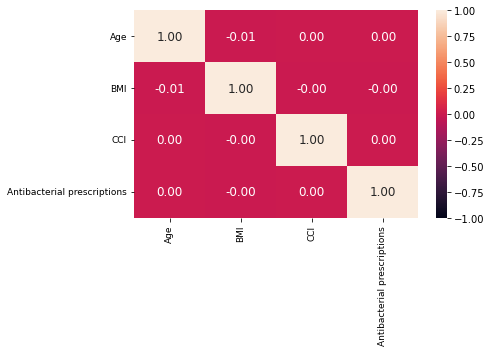

In [32]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(data_lrti[['age', 'bmi', 'CCI', 'antibacterial_brit']].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions'], rotation=90, fontsize=9)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions',], rotation=0, fontsize=9)                        
plt.tight_layout()
plt.savefig('../output/hospitalisation_prediction_lrti/corr_lrti.jpg')
plt.show()

## 4- separate data of incident/prevalent and with/without antibiotics and stratified sub-datasets

In [33]:
data_lrti = data_lrti[['age_cat', 'sex', 'CCI_cat', 'flu_vaccine', 'bmi_cat', 'region', 'imd', 'ethnicity', 'smoking', 'season', 
                                   'antibacterial_brit', 'lrti_ab_date', 'ab_type_cat', 'incdt_lrti_date', 'date', 'period',
                                   'event_lrti_admitted', 'duration_lrti_admitted'
                                    ]]

In [34]:
#switch variable lrti_ab_date into a binary variable
data_lrti[['ab_binary']] = data_lrti[['lrti_ab_date']].where(data_lrti[['lrti_ab_date']].isnull(), 1).fillna(0).astype(int)
#incident and prevalent infection 
data_lrti_incdt = data_lrti[data_lrti['incdt_lrti_date'] == 0]
data_lrti_prevl = data_lrti[data_lrti['incdt_lrti_date'] == 1]

#no antibiotics and incident hospital admission
data_lrti_no_abs_incdt = data_lrti_incdt[data_lrti_incdt['ab_binary'] == 0]
#with antibiotics and incident hospital admission
data_lrti_abs_incdt = data_lrti_incdt[data_lrti_incdt['ab_binary'] == 1]

#no antibiotics and prevalent hospital admission
data_lrti_no_abs_prevl = data_lrti_prevl[data_lrti_prevl['ab_binary'] == 0]
#with antibiotics and prevalent hospital admission
data_lrti_abs_prevl = data_lrti_prevl[data_lrti_prevl['ab_binary'] == 1]

In [35]:
##subcohorts for stratification by period
#incident and prevalent infection stratified by time period categories
data_lrti_incdt_prepandemic = data_lrti_incdt[data_lrti_incdt['period'] == 'prepandemic']
data_lrti_incdt_during_pandemic = data_lrti_incdt[(data_lrti_incdt['period'] == 'during_pandemic')]
data_lrti_incdt_post_2nd_lockdown = data_lrti_incdt[data_lrti_incdt['period'] == 'post_2nd_lockdown']
data_lrti_prevl_prepandemic = data_lrti_prevl[data_lrti_prevl['period'] == 'prepandemic']
data_lrti_prevl_during_pandemic = data_lrti_prevl[(data_lrti_prevl['period'] == 'during_pandemic')]
data_lrti_prevl_post_2nd_lockdown = data_lrti_prevl[data_lrti_prevl['period'] == 'post_2nd_lockdown']

#no antibiotics and incident hospital admission
data_lrti_no_abs_incdt_prepandemic = data_lrti_incdt_prepandemic[data_lrti_incdt_prepandemic['ab_binary'] == 0]
data_lrti_no_abs_incdt_during_pandemic = data_lrti_incdt_during_pandemic[data_lrti_incdt_during_pandemic['ab_binary'] == 0]
data_lrti_no_abs_incdt_post_2nd_lockdown = data_lrti_incdt_post_2nd_lockdown[data_lrti_incdt_post_2nd_lockdown['ab_binary'] == 0]
data_lrti_no_abs_prevl_prepandemic = data_lrti_prevl_prepandemic[data_lrti_prevl_prepandemic['ab_binary'] == 0]
data_lrti_no_abs_prevl_during_pandemic = data_lrti_prevl_during_pandemic[data_lrti_prevl_during_pandemic['ab_binary'] == 0]
data_lrti_no_abs_prevl_post_2nd_lockdown = data_lrti_prevl_post_2nd_lockdown[data_lrti_prevl_post_2nd_lockdown['ab_binary'] == 0]

In [36]:
#store data for plotting hosp admission counts and percentages
%store data_lrti
# save data
data_lrti.to_csv('../output/hospitalisation_prediction_lrti/data_lrti.csv')

Stored 'data_lrti' (DataFrame)


## 5- modelling of antibiotics prediction based on risk of hospital admission
### 5-0- summary tables

In [37]:
#make summary tables
make_summary_table('lrti', 'no_abs_incdt', data_lrti_no_abs_incdt)
make_summary_table('lrti', 'abs_incdt', data_lrti_abs_incdt)
make_summary_table('lrti', 'no_abs_prevl', data_lrti_no_abs_prevl)
make_summary_table('lrti', 'abs_prevl', data_lrti_abs_prevl)

### 5-1- incident

<lifelines.CoxPHFitter: fitted with 109932 total observations, 109234 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 109932
number of events observed = 698
   partial log-likelihood = -8081.10
         time fit was run = 2023-07-10 18:27:41 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.13       0.88       0.11            -0.34             0.09                 0.71                 1.09
CCI_cat[T.medium]               -0.00       1.00       0.12            -0.24             0.23                 0.79                 1.26
CCI_cat[T.high]                 -0.09       0.91       0.15            -0.38             0.20                 0.68                 1.22
CCI_cat[T.very_high]            -0.06       0.94       0.13            -0.31             0.19                 0.73                 1.21
age_cat[T.25_34]                -0.03       0.97       0.14            -0.30             0.24                 0.74                 1.27
age_cat[T.35_44]                -0.02       0.98       0.14            -0.28             0.25                 0.75                 1.29
age_cat[T.45_54]                -0.10       0.91       0.14            -0.37             0.18                 0.69                 1.20
age_cat[T.55_64]                -0.23       0.79       0.14            -0.52             0.05                 0.60                 1.05
age_cat[T.65_74]                -0.16       0.85       0.14            -0.44             0.12                 0.65                 1.13
age_cat[T.75_more]              -0.01       0.99       0.14            -0.28             0.26                 0.76                 1.29
antibacterial_brit               0.02       1.02       0.03            -0.03             0.07                 0.97                 1.08
bmi_cat[T.obese]                 0.27       1.30       0.16            -0.04             0.57                 0.96                 1.77
bmi_cat[T.overweight]            0.28       1.32       0.19            -0.08             0.64                 0.92                 1.90
bmi_cat[T.underweight]           0.45       1.57       0.24            -0.02             0.92                 0.98                 2.51
bmi_cat[T.unknown]               0.19       1.21       0.17            -0.14             0.52                 0.87                 1.67
ethnicity[T.other]               0.17       1.19       0.20            -0.21             0.56                 0.81                 1.75
ethnicity[T.unknown]             0.16       1.18       0.16            -0.16             0.48                 0.86                 1.62
ethnicity[T.white]               0.07       1.08       0.15            -0.23             0.38                 0.80                 1.46
flu_vaccine[T.yes]               0.28       1.32       0.11             0.06             0.51                 1.06                 1.66
imd[T.medium]                    0.11       1.11       0.12            -0.13             0.35                 0.88                 1.41
imd[T.unaffluent]                0.19       1.20       0.12            -0.05             0.42                 0.95                 1.52
imd[T.unknown]                  -0.13       0.88       0.21            -0.53             0.28                 0.59                 1.32
imd[T.very_affluent]            -0.11       0.89       0.13            -0.36             0.14                 0.69                 1.15
imd[T.very_unaffluent]           0.02       1.02       0.12            -0.22             0.26                 0.80                 1.30
region[T.east_midlands]          0.07       1.07       0.17      

13045


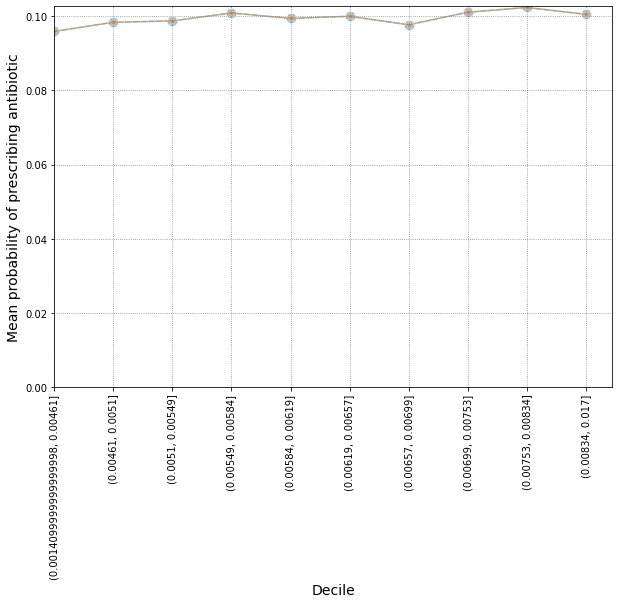


AUROC of LR for deciles with development and validation data: 0.50183 and 0.49834
AUROC of RF for deciles with development and validation data: 0.50433 and 0.50729
LR coefficients:
                                OR  Lower CI  Upper CI
bins_(0.00461, 0.0051]   0.109098  0.102766  0.115819
bins_(0.0051, 0.00549]   0.110469  0.104134  0.117190
bins_(0.00549, 0.00584]  0.110230  0.103873  0.116975
bins_(0.00584, 0.00619]  0.109645  0.103314  0.116364
bins_(0.00619, 0.00657]  0.112452  0.106015  0.119280
bins_(0.00657, 0.00699]  0.109055  0.102752  0.115744
bins_(0.00699, 0.00753]  0.112185  0.105765  0.118996
bins_(0.00753, 0.00834]  0.113514  0.107062  0.120356
bins_(0.00834, 0.017]    0.112042  0.105632  0.118840

RF feature importance:
                           rf_coef
bins_(0.00753, 0.00834]  0.151290
bins_(0.00619, 0.00657]  0.133210
bins_(0.00834, 0.017]    0.120252
bins_(0.00699, 0.00753]  0.111179
bins_(0.00584, 0.00619]  0.106139
bins_(0.00657, 0.00699]  0.100884
bins_(0.0051, 

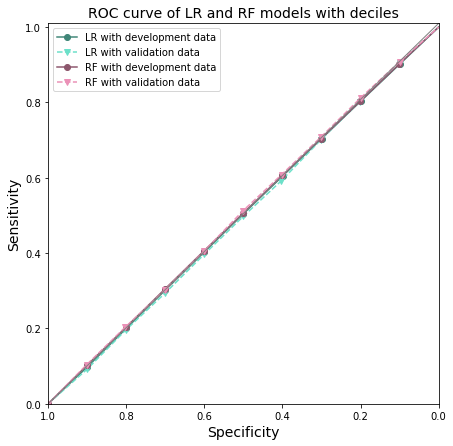

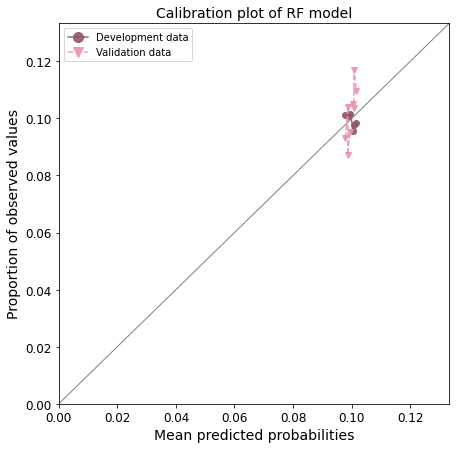

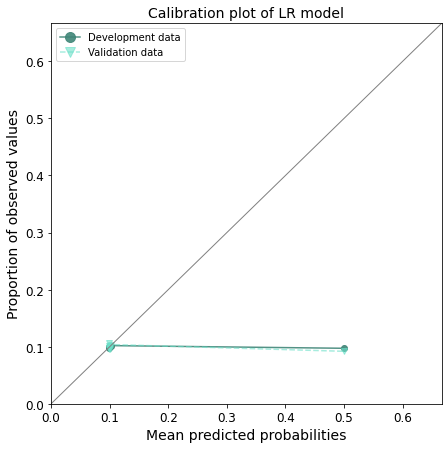


AUROC of LR for risk factors with development and validation data: 0.50253 and 0.50156
AUROC of RF for risk factors with development and validation data: 0.60199 and 0.50203
LR coefficients:
                                    OR  Lower CI  Upper CI
age_cat_25_34                0.678669  0.635991  0.724210
age_cat_35_44                0.735676  0.690277  0.784061
age_cat_45_54                0.706886  0.662832  0.753869
age_cat_55_64                0.686944  0.644024  0.732724
age_cat_65_74                0.710205  0.666137  0.757187
age_cat_75_more              0.674000  0.631492  0.719371
sex_male                     0.925371  0.892098  0.959885
CCI_cat_high                 0.769929  0.717003  0.826761
CCI_cat_low                  0.775253  0.737157  0.815318
CCI_cat_medium               0.776664  0.733583  0.822275
CCI_cat_very_high            0.809028  0.762140  0.858801
flu_vaccine_no               0.638527  0.607273  0.671389
bmi_cat_obese                0.623213  0.589870  0.65

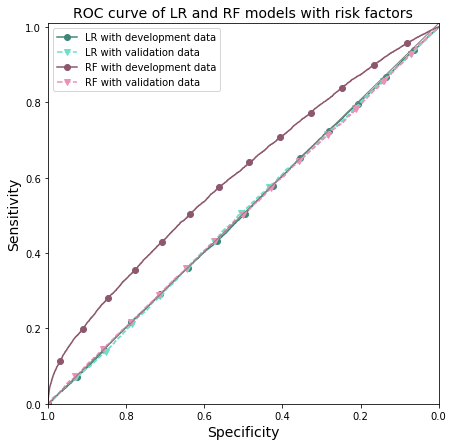

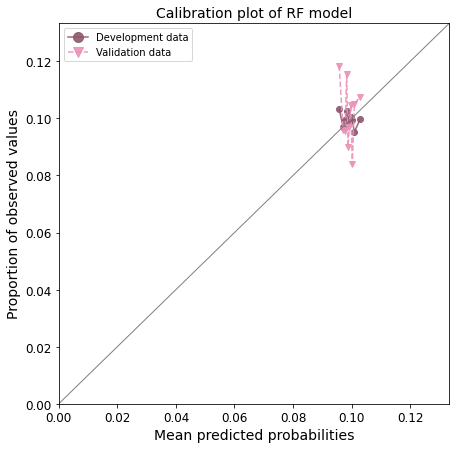

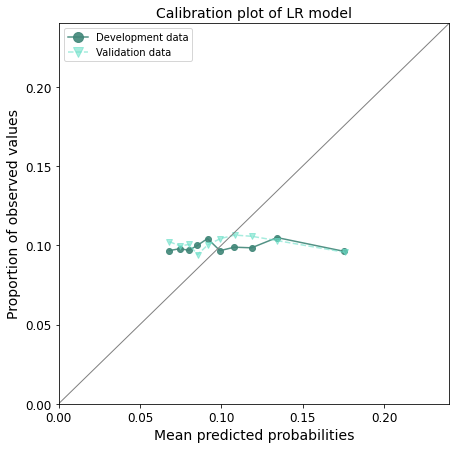

In [40]:
#build cox model for hosp prediction using non ab users' data
prob_pred_lrti_no_abs_incdt, prob_pred_lrti_no_abs_incdt_bin = cox_build('lrti', 'incdt', data_lrti_incdt, data_lrti_no_abs_incdt)

#build rf and lr models with deciles as predictors
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt = lr_rf_build_risk_deciles('lrti', 'incdt_deciles', prob_pred_lrti_no_abs_incdt)

#make summary table of deciles
make_summary_table_deciles('lrti', 'incdt', prob_pred_enc_lr_rf_incdt)

#calibration plots of rf and lr with deciles
calibration_rf_lr('lrti', 'incdt_deciles', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt)

#build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
prob_pred_enc_lr_rf_incdt, data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt = lr_rf_build_risk_riskfactors('lrti', 'incdt_riskfactors', prob_pred_lrti_no_abs_incdt)

#calibration plots of rf and lr with risk factors
calibration_rf_lr('lrti', 'incdt_riskfactors', data_enc_dev_incdt, data_enc_val_incdt, lr_pred_dev_incdt, lr_pred_val_incdt, rf_pred_dev_incdt, rf_pred_val_incdt)

#### 5-2- prevalent

<lifelines.CoxPHFitter: fitted with 12219 total observations, 12140 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 12219
number of events observed = 79
   partial log-likelihood = -726.20
         time fit was run = 2023-07-10 18:28:22 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.09       1.09       0.32            -0.54             0.72                 0.58                 2.05
CCI_cat[T.medium]               -0.14       0.87       0.37            -0.87             0.59                 0.42                 1.81
CCI_cat[T.high]                 -0.36       0.70       0.49            -1.32             0.60                 0.27                 1.82
CCI_cat[T.very_high]            -0.15       0.86       0.39            -0.92             0.62                 0.40                 1.86
age_cat[T.25_34]                -0.02       0.98       0.43            -0.86             0.82                 0.42                 2.27
age_cat[T.35_44]                 0.17       1.19       0.41            -0.63             0.98                 0.53                 2.66
age_cat[T.45_54]                 0.10       1.11       0.42            -0.72             0.92                 0.49                 2.52
age_cat[T.55_64]                -0.03       0.97       0.43            -0.87             0.81                 0.42                 2.24
age_cat[T.65_74]                -0.07       0.93       0.43            -0.91             0.76                 0.40                 2.14
age_cat[T.75_more]              -0.08       0.92       0.44            -0.94             0.77                 0.39                 2.17
antibacterial_brit               0.04       1.04       0.08            -0.12             0.19                 0.89                 1.21
bmi_cat[T.obese]                -0.11       0.90       0.44            -0.97             0.76                 0.38                 2.14
bmi_cat[T.overweight]            0.58       1.78       0.48            -0.37             1.53                 0.69                 4.60
bmi_cat[T.underweight]           0.80       2.23       0.61            -0.39             1.99                 0.68                 7.33
bmi_cat[T.unknown]              -0.01       0.99       0.47            -0.93             0.92                 0.39                 2.50
ethnicity[T.other]               0.73       2.07       0.61            -0.47             1.93                 0.62                 6.88
ethnicity[T.unknown]             0.35       1.42       0.55            -0.73             1.43                 0.48                 4.19
ethnicity[T.white]               0.36       1.43       0.52            -0.66             1.38                 0.52                 3.98
flu_vaccine[T.yes]              -0.67       0.51       0.51            -1.68             0.33                 0.19                 1.40
imd[T.medium]                   -0.18       0.83       0.45            -1.06             0.70                 0.35                 2.02
imd[T.unaffluent]                0.59       1.81       0.38            -0.14             1.33                 0.87                 3.78
imd[T.unknown]                   0.77       2.15       0.51            -0.23             1.76                 0.79                 5.83
imd[T.very_affluent]             0.37       1.44       0.39            -0.40             1.14                 0.67                 3.11
imd[T.very_unaffluent]           0.45       1.57       0.39            -0.31             1.21                 0.73                 3.35
region[T.east_midlands]         -0.15       0.86       0.45           

13047


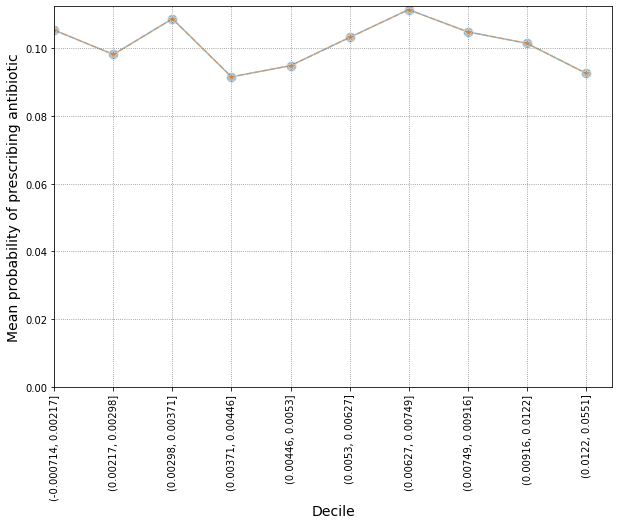


AUROC of LR for deciles with development and validation data: 0.52657 and 0.49304
AUROC of RF for deciles with development and validation data: 0.52887 and 0.49027
LR coefficients:
                                OR  Lower CI  Upper CI
bins_(0.00217, 0.00298]  0.105892  0.088561  0.126614
bins_(0.00298, 0.00371]  0.116776  0.098145  0.138945
bins_(0.00371, 0.00446]  0.097930  0.081376  0.117852
bins_(0.00446, 0.0053]   0.096434  0.079896  0.116396
bins_(0.0053, 0.00627]   0.116411  0.097959  0.138338
bins_(0.00627, 0.00749]  0.133277  0.112833  0.157425
bins_(0.00749, 0.00916]  0.123932  0.104290  0.147273
bins_(0.00916, 0.0122]   0.107113  0.089265  0.128530
bins_(0.0122, 0.0551]    0.098335  0.081770  0.118254

RF feature importance:
                           rf_coef
bins_(0.00627, 0.00749]  0.249813
bins_(0.00446, 0.0053]   0.149257
bins_(0.0122, 0.0551]    0.129525
bins_(0.00371, 0.00446]  0.120215
bins_(0.00749, 0.00916]  0.107389
bins_(0.00298, 0.00371]  0.070497
bins_(0.0053, 

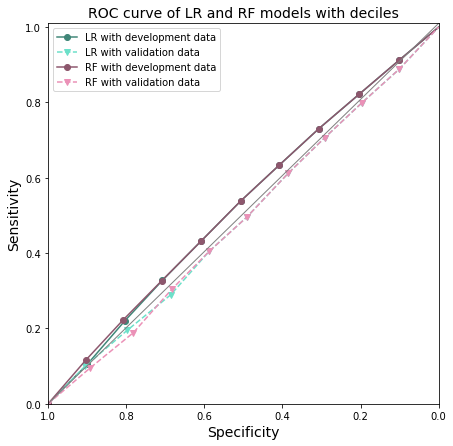

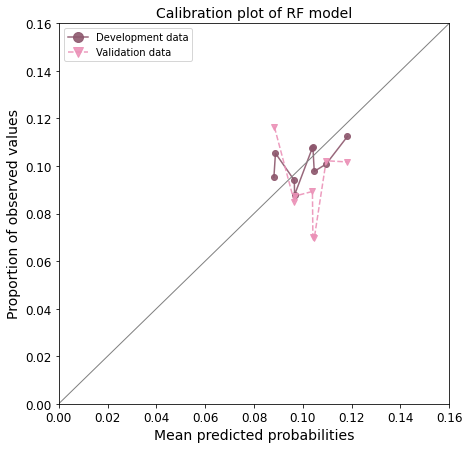

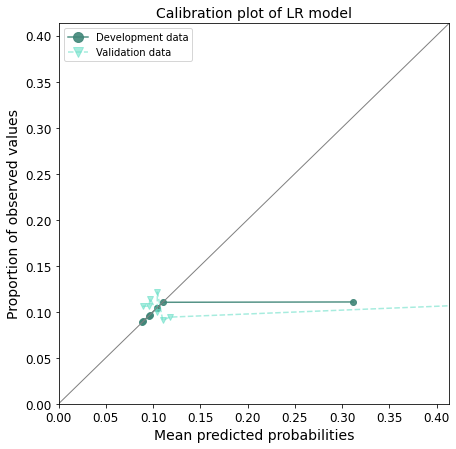


AUROC of LR for risk factors with development and validation data: 0.52780 and 0.47787
AUROC of RF for risk factors with development and validation data: 0.76413 and 0.48525
LR coefficients:
                                    OR  Lower CI  Upper CI
age_cat_25_34                0.756889  0.623444  0.918898
age_cat_35_44                0.726463  0.596563  0.884648
age_cat_45_54                0.731773  0.600466  0.891793
age_cat_55_64                0.771279  0.634798  0.937102
age_cat_65_74                0.872745  0.724802  1.050885
age_cat_75_more              0.784424  0.644829  0.954239
sex_male                     0.886728  0.794493  0.989671
CCI_cat_high                 0.813453  0.659135  1.003900
CCI_cat_low                  0.844691  0.726197  0.982520
CCI_cat_medium               0.764742  0.642705  0.909952
CCI_cat_very_high            0.829135  0.691793  0.993745
flu_vaccine_no               0.639770  0.549672  0.744636
bmi_cat_obese                0.580629  0.493076  0.68

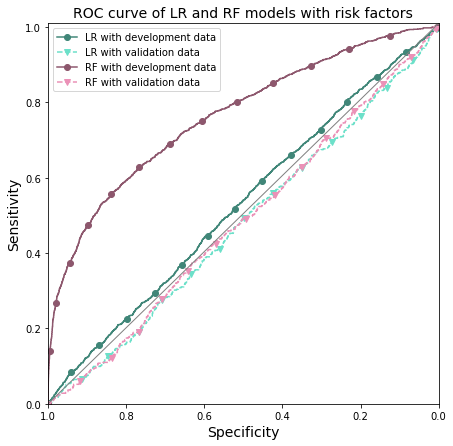

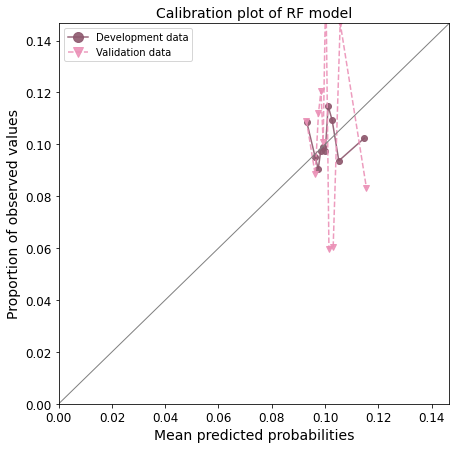

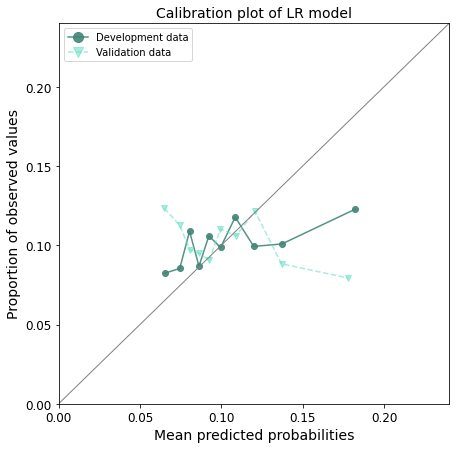

In [41]:
#build cox model for hosp prediction using non ab users' data
prob_pred_lrti_no_abs_prevl, prob_pred_lrti_no_abs_prevl_bin = cox_build('lrti', 'prevl', data_lrti_prevl, data_lrti_no_abs_prevl)

#build rf and lr models with deciles as predictors
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl = lr_rf_build_risk_deciles('lrti', 'prevl_deciles', prob_pred_lrti_no_abs_prevl)

#make summary table of deciles
make_summary_table_deciles('lrti', 'prevl', prob_pred_enc_lr_rf_prevl)

#calibration plots of rf and lr with deciles
calibration_rf_lr('lrti', 'prevl_deciles', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl)

#build rf and lr models with all risk factors (e.g. age, sex, ethnicity) as predictors
prob_pred_enc_lr_rf_prevl, data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl = lr_rf_build_risk_riskfactors('lrti', 'prevl_riskfactors', prob_pred_lrti_no_abs_prevl)

#calibration plots of rf and lr with risk factors
calibration_rf_lr('lrti', 'prevl_riskfactors', data_enc_dev_prevl, data_enc_val_prevl, lr_pred_dev_prevl, lr_pred_val_prevl, rf_pred_dev_prevl, rf_pred_val_prevl)

#### 5-3- stratification by time period
#### 5-3-1- incident

<lifelines.CoxPHFitter: fitted with 28560 total observations, 28405 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 28560
number of events observed = 155
   partial log-likelihood = -1560.79
         time fit was run = 2023-07-10 18:28:39 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.12       0.89       0.23            -0.57             0.33                 0.56                 1.40
CCI_cat[T.medium]                0.02       1.02       0.25            -0.47             0.51                 0.63                 1.66
CCI_cat[T.high]                 -1.12       0.33       0.45            -2.00            -0.24                 0.14                 0.78
CCI_cat[T.very_high]             0.06       1.06       0.26            -0.44             0.57                 0.64                 1.77
age_cat[T.25_34]                 0.07       1.07       0.30            -0.51             0.66                 0.60                 1.93
age_cat[T.35_44]                -0.04       0.96       0.31            -0.64             0.56                 0.53                 1.75
age_cat[T.45_54]                 0.01       1.01       0.30            -0.58             0.60                 0.56                 1.83
age_cat[T.55_64]                -0.19       0.82       0.32            -0.82             0.43                 0.44                 1.54
age_cat[T.65_74]                -0.38       0.68       0.34            -1.04             0.28                 0.35                 1.32
age_cat[T.75_more]               0.47       1.60       0.27            -0.07             1.01                 0.93                 2.73
antibacterial_brit              -0.00       1.00       0.06            -0.11             0.11                 0.89                 1.11
bmi_cat[T.obese]                 0.01       1.01       0.29            -0.56             0.57                 0.57                 1.78
bmi_cat[T.overweight]           -0.09       0.91       0.37            -0.81             0.63                 0.44                 1.87
bmi_cat[T.underweight]           0.50       1.65       0.43            -0.34             1.34                 0.71                 3.81
bmi_cat[T.unknown]              -0.30       0.74       0.32            -0.94             0.33                 0.39                 1.39
ethnicity[T.other]               0.22       1.24       0.42            -0.61             1.04                 0.54                 2.83
ethnicity[T.unknown]             0.35       1.42       0.35            -0.33             1.03                 0.72                 2.80
ethnicity[T.white]              -0.00       1.00       0.34            -0.66             0.66                 0.52                 1.93
flu_vaccine[T.yes]               0.49       1.63       0.23             0.04             0.94                 1.04                 2.56
imd[T.medium]                   -0.13       0.88       0.23            -0.58             0.32                 0.56                 1.38
imd[T.unaffluent]               -0.43       0.65       0.25            -0.93             0.06                 0.40                 1.06
imd[T.unknown]                  -0.28       0.75       0.39            -1.04             0.48                 0.35                 1.61
imd[T.very_affluent]            -0.67       0.51       0.27            -1.20            -0.14                 0.30                 0.87
imd[T.very_unaffluent]          -0.52       0.60       0.26            -1.03            -0.01                 0.36                 0.99
region[T.east_midlands]         -0.08       0.92       0.40         

13048


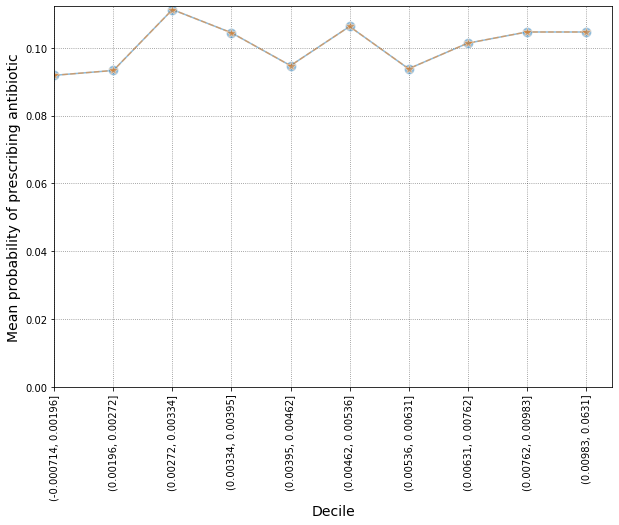


AUROC of LR for deciles with development and validation data: 0.50818 and 0.50583
AUROC of RF for deciles with development and validation data: 0.51637 and 0.52299
LR coefficients:
                                OR  Lower CI  Upper CI
bins_(0.00196, 0.00272]  0.103544  0.091902  0.116661
bins_(0.00272, 0.00334]  0.117790  0.105252  0.131822
bins_(0.00334, 0.00395]  0.121201  0.108353  0.135573
bins_(0.00395, 0.00462]  0.104503  0.092859  0.117608
bins_(0.00462, 0.00536]  0.117021  0.104410  0.131156
bins_(0.00536, 0.00631]  0.107032  0.095184  0.120354
bins_(0.00631, 0.00762]  0.112686  0.100350  0.126538
bins_(0.00762, 0.00983]  0.117521  0.104853  0.131720
bins_(0.00983, 0.0631]   0.118063  0.105406  0.132240

RF feature importance:
                           rf_coef
bins_(0.00334, 0.00395]  0.161080
bins_(0.00272, 0.00334]  0.130701
bins_(0.00395, 0.00462]  0.125984
bins_(0.00196, 0.00272]  0.120300
bins_(0.00762, 0.00983]  0.103191
bins_(0.00462, 0.00536]  0.099492
bins_(0.00983,

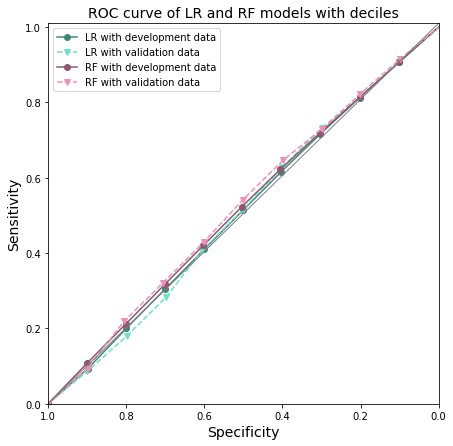

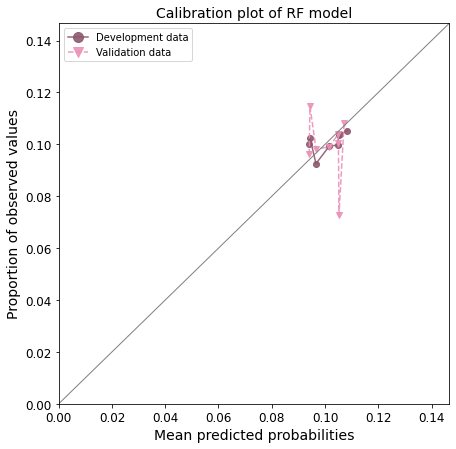

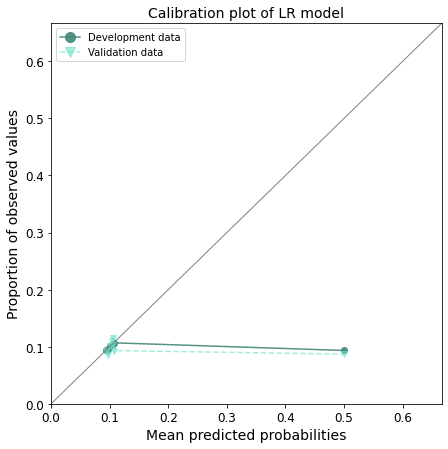

In [42]:
#build cox model for hosp prediction using non ab users' data
prob_pred_lrti_no_abs_incdt_prepandemic, prob_pred_lrti_no_abs_incdt_prepandemic_bin = cox_build('lrti', 'incdt_prepandemic', data_lrti_incdt_prepandemic, data_lrti_no_abs_incdt_prepandemic)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_prepandemic, data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic = lr_rf_build_risk_deciles('lrti', 'incdt_prepandemic_deciles', prob_pred_lrti_no_abs_incdt_prepandemic)

#calibration plots of rf and lr
calibration_rf_lr('lrti', 'incdt_prepandemic', data_enc_dev_incdt_prepandemic, data_enc_val_incdt_prepandemic, lr_pred_dev_incdt_prepandemic, lr_pred_val_incdt_prepandemic, rf_pred_dev_incdt_prepandemic, rf_pred_val_incdt_prepandemic)

<lifelines.CoxPHFitter: fitted with 33134 total observations, 32923 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 33134
number of events observed = 211
   partial log-likelihood = -2183.37
         time fit was run = 2023-07-10 18:28:55 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.17       0.85       0.21            -0.57             0.24                 0.57                 1.27
CCI_cat[T.medium]                0.06       1.06       0.22            -0.37             0.49                 0.69                 1.63
CCI_cat[T.high]                 -0.07       0.93       0.27            -0.61             0.47                 0.55                 1.59
CCI_cat[T.very_high]             0.04       1.04       0.23            -0.41             0.49                 0.66                 1.63
age_cat[T.25_34]                 0.01       1.01       0.25            -0.48             0.50                 0.62                 1.65
age_cat[T.35_44]                -0.22       0.80       0.26            -0.74             0.29                 0.48                 1.34
age_cat[T.45_54]                 0.00       1.00       0.25            -0.49             0.49                 0.62                 1.63
age_cat[T.55_64]                -0.16       0.85       0.26            -0.66             0.35                 0.51                 1.42
age_cat[T.65_74]                -0.13       0.87       0.25            -0.63             0.36                 0.53                 1.44
age_cat[T.75_more]              -0.09       0.91       0.25            -0.59             0.41                 0.56                 1.51
antibacterial_brit               0.02       1.02       0.05            -0.07             0.11                 0.93                 1.12
bmi_cat[T.obese]                 0.21       1.23       0.27            -0.33             0.75                 0.72                 2.11
bmi_cat[T.overweight]            0.06       1.06       0.34            -0.61             0.72                 0.55                 2.06
bmi_cat[T.underweight]           0.30       1.35       0.44            -0.56             1.16                 0.57                 3.19
bmi_cat[T.unknown]               0.03       1.03       0.30            -0.55             0.61                 0.58                 1.84
ethnicity[T.other]               0.21       1.23       0.36            -0.50             0.92                 0.61                 2.51
ethnicity[T.unknown]             0.10       1.10       0.30            -0.49             0.69                 0.61                 1.99
ethnicity[T.white]               0.14       1.16       0.28            -0.41             0.70                 0.67                 2.01
flu_vaccine[T.yes]              -0.05       0.95       0.24            -0.51             0.41                 0.60                 1.51
imd[T.medium]                    0.09       1.09       0.21            -0.33             0.51                 0.72                 1.66
imd[T.unaffluent]                0.03       1.03       0.22            -0.40             0.46                 0.67                 1.59
imd[T.unknown]                  -0.21       0.81       0.37            -0.93             0.51                 0.39                 1.66
imd[T.very_affluent]            -0.22       0.81       0.23            -0.67             0.24                 0.51                 1.27
imd[T.very_unaffluent]          -0.07       0.93       0.22            -0.51             0.37                 0.60                 1.45
region[T.east_midlands]         -0.05       0.95       0.31         

13045


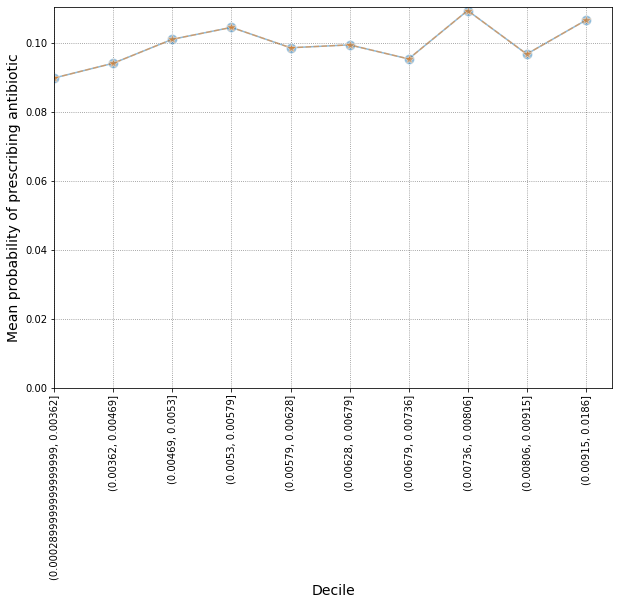


AUROC of LR for deciles with development and validation data: 0.50667 and 0.50127
AUROC of RF for deciles with development and validation data: 0.51877 and 0.50702
LR coefficients:
                                OR  Lower CI  Upper CI
bins_(0.00362, 0.00469]  0.106627  0.095559  0.118975
bins_(0.00469, 0.0053]   0.111213  0.099799  0.123933
bins_(0.0053, 0.00579]   0.110909  0.099542  0.123573
bins_(0.00579, 0.00628]  0.104996  0.094061  0.117201
bins_(0.00628, 0.00679]  0.110442  0.099155  0.123015
bins_(0.00679, 0.00736]  0.104397  0.093499  0.116566
bins_(0.00736, 0.00806]  0.121000  0.109032  0.134281
bins_(0.00806, 0.00915]  0.105546  0.094596  0.117763
bins_(0.00915, 0.0186]   0.123623  0.111483  0.137085

RF feature importance:
                           rf_coef
bins_(0.00915, 0.0186]   0.294702
bins_(0.00736, 0.00806]  0.236916
bins_(0.0053, 0.00579]   0.083086
bins_(0.00469, 0.0053]   0.081204
bins_(0.00628, 0.00679]  0.071830
bins_(0.00806, 0.00915]  0.061604
bins_(0.00679,

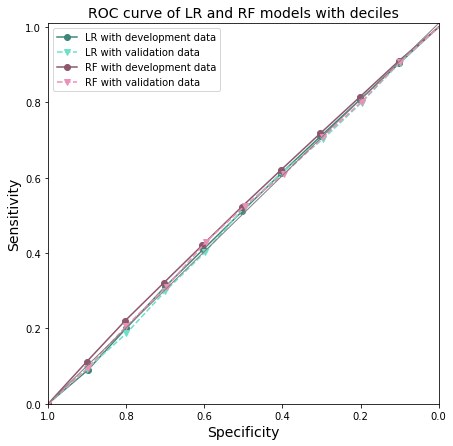

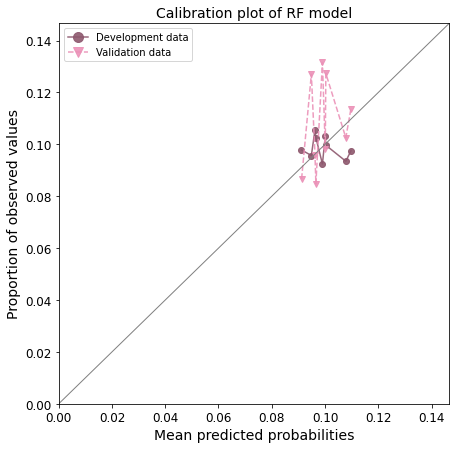

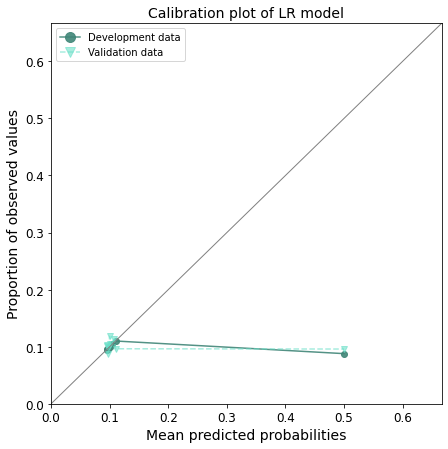

In [43]:
#build cox model for hosp prediction using non ab users' data
prob_pred_lrti_no_abs_incdt_during_pandemic, prob_pred_lrti_no_abs_incdt_during_pandemic_bin = cox_build('lrti', 'incdt_during_pandemic', data_lrti_incdt_during_pandemic, data_lrti_no_abs_incdt_during_pandemic)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_during_pandemic, data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic = lr_rf_build_risk_deciles('lrti', 'incdt_during_pandemic_deciles', prob_pred_lrti_no_abs_incdt_during_pandemic)

#calibration plots of rf and lr
calibration_rf_lr('lrti', 'incdt_during_pandemic', data_enc_dev_incdt_during_pandemic, data_enc_val_incdt_during_pandemic, lr_pred_dev_incdt_during_pandemic, lr_pred_val_incdt_during_pandemic, rf_pred_dev_incdt_during_pandemic, rf_pred_val_incdt_during_pandemic)

<lifelines.CoxPHFitter: fitted with 48237 total observations, 47906 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 48237
number of events observed = 331
   partial log-likelihood = -3545.18
         time fit was run = 2023-07-10 18:29:03 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.21       1.23       0.17            -0.13             0.55                 0.88                 1.73
CCI_cat[T.medium]                0.22       1.24       0.19            -0.15             0.58                 0.86                 1.79
CCI_cat[T.high]                  0.08       1.09       0.23            -0.37             0.54                 0.69                 1.71
CCI_cat[T.very_high]             0.23       1.25       0.19            -0.16             0.61                 0.86                 1.84
age_cat[T.25_34]                -0.15       0.86       0.20            -0.54             0.24                 0.58                 1.27
age_cat[T.35_44]                -0.13       0.87       0.20            -0.53             0.26                 0.59                 1.29
age_cat[T.45_54]                -0.05       0.95       0.20            -0.43             0.34                 0.65                 1.40
age_cat[T.55_64]                -0.47       0.62       0.22            -0.90            -0.04                 0.41                 0.96
age_cat[T.65_74]                -0.02       0.98       0.19            -0.40             0.36                 0.67                 1.43
age_cat[T.75_more]              -0.25       0.78       0.20            -0.65             0.16                 0.52                 1.17
antibacterial_brit               0.04       1.04       0.04            -0.03             0.12                 0.97                 1.12
bmi_cat[T.obese]                 0.40       1.49       0.24            -0.06             0.86                 0.94                 2.36
bmi_cat[T.overweight]            0.27       1.31       0.28            -0.28             0.82                 0.75                 2.28
bmi_cat[T.underweight]           0.35       1.42       0.38            -0.38             1.09                 0.68                 2.97
bmi_cat[T.unknown]               0.34       1.41       0.25            -0.15             0.83                 0.86                 2.30
ethnicity[T.other]               0.26       1.29       0.29            -0.30             0.82                 0.74                 2.26
ethnicity[T.unknown]             0.26       1.30       0.24            -0.21             0.73                 0.81                 2.07
ethnicity[T.white]               0.12       1.13       0.23            -0.32             0.56                 0.72                 1.75
flu_vaccine[T.yes]               0.21       1.24       0.17            -0.12             0.55                 0.89                 1.73
imd[T.medium]                    0.23       1.26       0.18            -0.13             0.59                 0.88                 1.80
imd[T.unaffluent]                0.20       1.23       0.18            -0.16             0.57                 0.85                 1.76
imd[T.unknown]                  -0.22       0.80       0.33            -0.87             0.42                 0.42                 1.53
imd[T.very_affluent]             0.27       1.30       0.18            -0.09             0.62                 0.91                 1.86
imd[T.very_unaffluent]           0.14       1.15       0.19            -0.23             0.51                 0.80                 1.66
region[T.east_midlands]         -0.02       0.98       0.24         

13049


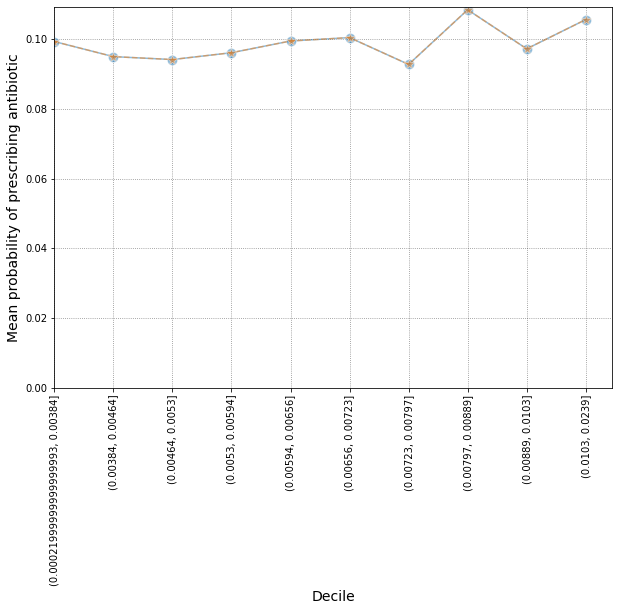


AUROC of LR for deciles with development and validation data: 0.51567 and 0.49994
AUROC of RF for deciles with development and validation data: 0.51772 and 0.49982
LR coefficients:
                                OR  Lower CI  Upper CI
bins_(0.00384, 0.00464]  0.104119  0.094940  0.114185
bins_(0.00464, 0.0053]   0.103392  0.094323  0.113332
bins_(0.0053, 0.00594]   0.109811  0.100433  0.120065
bins_(0.00594, 0.00656]  0.106574  0.097378  0.116639
bins_(0.00656, 0.00723]  0.111783  0.102237  0.122220
bins_(0.00723, 0.00797]  0.100946  0.091999  0.110763
bins_(0.00797, 0.00889]  0.123162  0.112968  0.134276
bins_(0.00889, 0.0103]   0.114625  0.104953  0.125188
bins_(0.0103, 0.0239]    0.121022  0.111014  0.131932

RF feature importance:
                           rf_coef
bins_(0.00797, 0.00889]  0.237661
bins_(0.0103, 0.0239]    0.180477
bins_(0.00723, 0.00797]  0.155478
bins_(0.00464, 0.0053]   0.110783
bins_(0.00384, 0.00464]  0.097248
bins_(0.00594, 0.00656]  0.068054
bins_(0.00889,

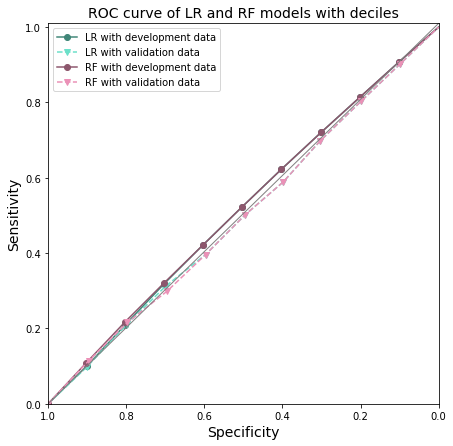

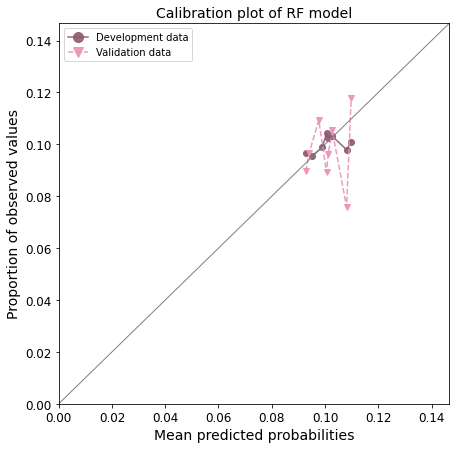

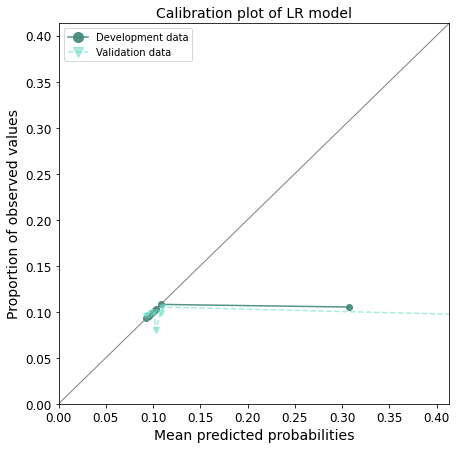

In [44]:
#build cox model for hosp prediction using non ab users' data
prob_pred_lrti_no_abs_incdt_post_2nd_lockdown, prob_pred_lrti_no_abs_incdt_post_2nd_lockdown_bin = cox_build('lrti', 'incdt_post_2nd_lockdown', data_lrti_incdt_post_2nd_lockdown, data_lrti_no_abs_incdt_post_2nd_lockdown)

#build rf and lr models
prob_pred_enc_lr_rf_incdt_post_2nd_lockdown, data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown = lr_rf_build_risk_deciles('lrti', 'incdt_post_2nd_lockdown_deciles', prob_pred_lrti_no_abs_incdt_post_2nd_lockdown)

#calibration plots of rf and lr
calibration_rf_lr('lrti', 'incdt_post_2nd_lockdown', data_enc_dev_incdt_post_2nd_lockdown, data_enc_val_incdt_post_2nd_lockdown, lr_pred_dev_incdt_post_2nd_lockdown, lr_pred_val_incdt_post_2nd_lockdown, rf_pred_dev_incdt_post_2nd_lockdown, rf_pred_val_incdt_post_2nd_lockdown)

#### 5-3-2- prevalent

<lifelines.CoxPHFitter: fitted with 3235 total observations, 3210 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 3235
number of events observed = 25
   partial log-likelihood = -183.05
         time fit was run = 2023-07-10 18:29:12 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.35       1.42       0.53            -0.68             1.38                 0.51                 3.99
CCI_cat[T.medium]               -0.13       0.88       0.64            -1.38             1.12                 0.25                 3.08
CCI_cat[T.high]                 -1.16       0.31       1.10            -3.32             0.99                 0.04                 2.70
CCI_cat[T.very_high]           -18.18       0.00    3890.17         -7642.77          7606.42                 0.00                  inf
age_cat[T.25_34]                -0.87       0.42       0.84            -2.52             0.79                 0.08                 2.20
age_cat[T.35_44]                -1.64       0.19       1.10            -3.80             0.52                 0.02                 1.69
age_cat[T.45_54]                 0.23       1.25       0.62            -0.98             1.43                 0.37                 4.20
age_cat[T.55_64]                 0.04       1.04       0.64            -1.22             1.30                 0.29                 3.67
age_cat[T.65_74]                -0.50       0.61       0.74            -1.94             0.95                 0.14                 2.58
age_cat[T.75_more]              -0.55       0.58       0.74            -2.00             0.90                 0.13                 2.46
antibacterial_brit               0.11       1.12       0.14            -0.16             0.38                 0.85                 1.47
bmi_cat[T.obese]                -0.94       0.39       0.61            -2.13             0.25                 0.12                 1.28
bmi_cat[T.overweight]           -0.12       0.88       0.72            -1.53             1.28                 0.22                 3.60
bmi_cat[T.underweight]         -18.56       0.00    8256.55        -16201.10         16163.98                 0.00                  inf
bmi_cat[T.unknown]              -0.56       0.57       0.64            -1.81             0.69                 0.16                 2.00
ethnicity[T.other]              17.89   5.87e+07    5564.30        -10887.94         10923.72                 0.00                  inf
ethnicity[T.unknown]            17.88   5.80e+07    5564.30        -10887.95         10923.70                 0.00                  inf
ethnicity[T.white]              17.80   5.39e+07    5564.30        -10888.03         10923.63                 0.00                  inf
flu_vaccine[T.yes]              -0.76       0.47       1.03            -2.78             1.26                 0.06                 3.52
imd[T.medium]                    0.27       1.31       0.77            -1.24             1.79                 0.29                 5.96
imd[T.unaffluent]                0.70       2.01       0.71            -0.70             2.10                 0.50                 8.14
imd[T.unknown]                   0.29       1.33       1.17            -2.00             2.57                 0.14                13.11
imd[T.very_affluent]             0.72       2.06       0.72            -0.68             2.13                 0.51                 8.38
imd[T.very_unaffluent]           0.54       1.71       0.74            -0.91             1.99                 0.40                 7.28
region[T.east_midlands]          0.25       1.29       0.77            -1

13109


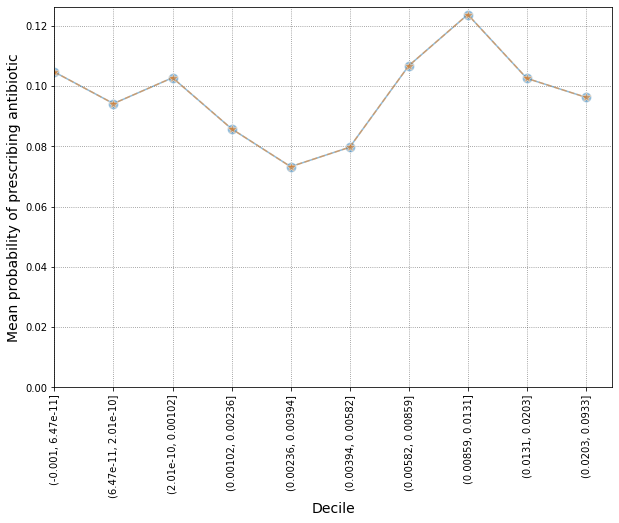


AUROC of LR for deciles with development and validation data: 0.55094 and 0.48865
AUROC of RF for deciles with development and validation data: 0.55177 and 0.49503
LR coefficients:
                                  OR  Lower CI  Upper CI
bins_(0.00102, 0.00236]    0.085960  0.059203  0.124809
bins_(0.00236, 0.00394]    0.077612  0.052076  0.115670
bins_(0.00394, 0.00582]    0.103976  0.073038  0.148017
bins_(0.00582, 0.00859]    0.107256  0.075303  0.152767
bins_(0.00859, 0.0131]     0.146032  0.107175  0.198976
bins_(0.0131, 0.0203]      0.121406  0.086699  0.170006
bins_(0.0203, 0.0933]      0.115894  0.081672  0.164456
bins_(2.01e-10, 0.00102]   0.113846  0.081027  0.159958
bins_(6.47e-11, 2.01e-10]  0.097264  0.067660  0.139822

RF feature importance:
                             rf_coef
bins_(0.00859, 0.0131]     0.205545
bins_(0.00236, 0.00394]    0.196449
bins_(0.00102, 0.00236]    0.154601
bins_(6.47e-11, 2.01e-10]  0.098632
bins_(0.00394, 0.00582]    0.075221
bins_(2.01e-10, 

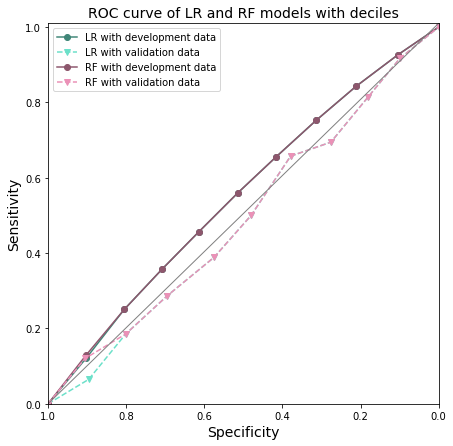

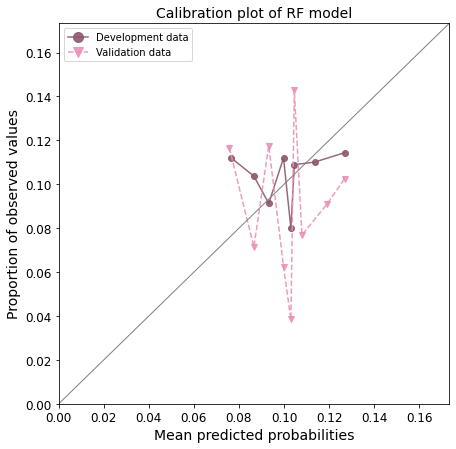

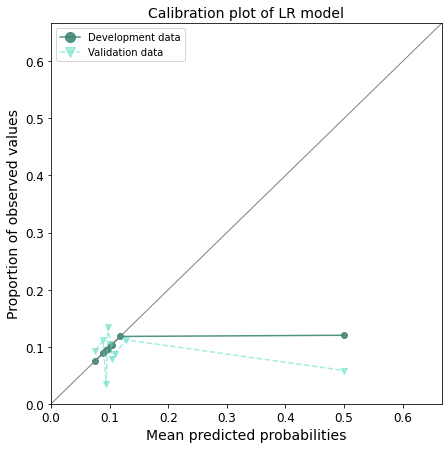

In [45]:
#build cox model for hosp prediction using non ab users' data
prob_pred_lrti_no_abs_prevl_prepandemic, prob_pred_lrti_no_abs_prevl_prepandemic_bin = cox_build('lrti', 'prevl_prepandemic', data_lrti_prevl_prepandemic, data_lrti_no_abs_prevl_prepandemic)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_prepandemic, data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic = lr_rf_build_risk_deciles('lrti', 'prevl_prepandemic_deciles', prob_pred_lrti_no_abs_prevl_prepandemic)

#calibration plots of rf and lr
calibration_rf_lr('lrti', 'prevl_prepandemic', data_enc_dev_prevl_prepandemic, data_enc_val_prevl_prepandemic, lr_pred_dev_prevl_prepandemic, lr_pred_val_prevl_prepandemic, rf_pred_dev_prevl_prepandemic, rf_pred_val_prevl_prepandemic)

<lifelines.CoxPHFitter: fitted with 3641 total observations, 3621 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 3641
number of events observed = 20
   partial log-likelihood = -144.98
         time fit was run = 2023-07-10 18:29:16 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                   0.50       1.65       0.81            -1.09             2.09                 0.34                 8.11
CCI_cat[T.medium]                0.68       1.98       0.85            -0.98             2.34                 0.38                10.41
CCI_cat[T.high]                  0.39       1.47       1.01            -1.59             2.37                 0.20                10.67
CCI_cat[T.very_high]             0.68       1.97       0.88            -1.04             2.40                 0.35                11.04
age_cat[T.25_34]                -0.73       0.48       1.23            -3.15             1.69                 0.04                 5.40
age_cat[T.35_44]                 0.23       1.26       1.01            -1.75             2.20                 0.17                 9.06
age_cat[T.45_54]                 0.77       2.16       0.88            -0.96             2.50                 0.38                12.20
age_cat[T.55_64]                 0.42       1.52       0.92            -1.38             2.23                 0.25                 9.27
age_cat[T.65_74]                 0.87       2.40       0.85            -0.78             2.53                 0.46                12.57
age_cat[T.75_more]               0.53       1.70       0.93            -1.28             2.34                 0.28                10.41
antibacterial_brit               0.07       1.07       0.16            -0.24             0.37                 0.78                 1.45
bmi_cat[T.obese]                 0.52       1.68       1.06            -1.56             2.59                 0.21                13.34
bmi_cat[T.overweight]            0.69       1.98       1.17            -1.61             2.98                 0.20                19.78
bmi_cat[T.underweight]           1.00       2.71       1.45            -1.84             3.83                 0.16                46.07
bmi_cat[T.unknown]              -0.14       0.87       1.17            -2.44             2.16                 0.09                 8.68
ethnicity[T.other]              -0.43       0.65       0.93            -2.26             1.40                 0.10                 4.05
ethnicity[T.unknown]            -1.24       0.29       0.83            -2.87             0.39                 0.06                 1.48
ethnicity[T.white]              -0.79       0.46       0.66            -2.08             0.51                 0.13                 1.66
flu_vaccine[T.yes]             -17.79       0.00    5461.67        -10722.46         10686.88                 0.00                  inf
imd[T.medium]                    0.37       1.45       0.77            -1.15             1.89                 0.32                 6.60
imd[T.unaffluent]                0.37       1.44       0.78            -1.15             1.89                 0.32                 6.61
imd[T.unknown]                   1.49       4.44       0.84            -0.16             3.14                 0.85                23.17
imd[T.very_affluent]             0.29       1.34       0.77            -1.22             1.80                 0.30                 6.08
imd[T.very_unaffluent]          -0.38       0.68       0.92            -2.19             1.42                 0.11                 4.15
region[T.east_midlands]         18.51   1.10e+08    5799.40        -11348

13203


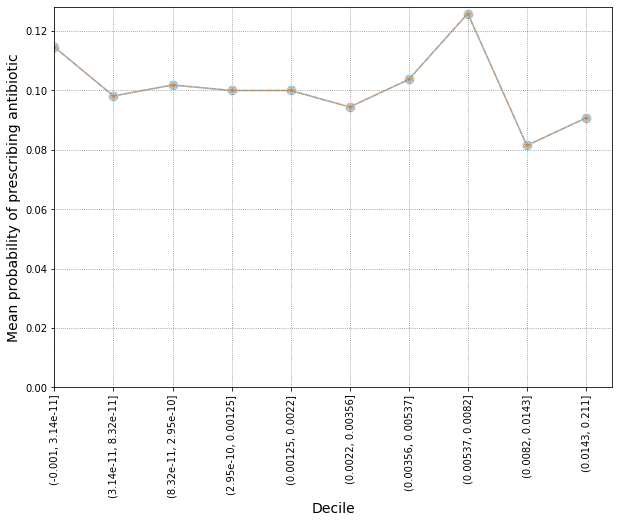


AUROC of LR for deciles with development and validation data: 0.52021 and 0.55974
AUROC of RF for deciles with development and validation data: 0.52120 and 0.55984
LR coefficients:
                                  OR  Lower CI  Upper CI
bins_(0.00125, 0.0022]     0.116022  0.084292  0.159696
bins_(0.0022, 0.00356]     0.111421  0.080367  0.154473
bins_(0.00356, 0.00537]    0.120219  0.087933  0.164358
bins_(0.00537, 0.0082]     0.127841  0.093737  0.174352
bins_(0.0082, 0.0143]      0.091667  0.064179  0.130927
bins_(0.0143, 0.211]       0.110497  0.079712  0.153172
bins_(2.95e-10, 0.00125]   0.122616  0.089971  0.167105
bins_(3.14e-11, 8.32e-11]  0.112329  0.081337  0.155129
bins_(8.32e-11, 2.95e-10]  0.109920  0.079620  0.151749

RF feature importance:
                             rf_coef
bins_(0.0082, 0.0143]      0.182933
bins_(0.00537, 0.0082]     0.135539
bins_(0.0143, 0.211]       0.106796
bins_(2.95e-10, 0.00125]   0.103410
bins_(0.0022, 0.00356]     0.100161
bins_(0.00356, 0

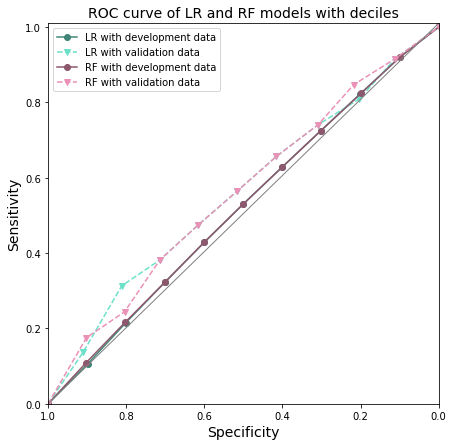

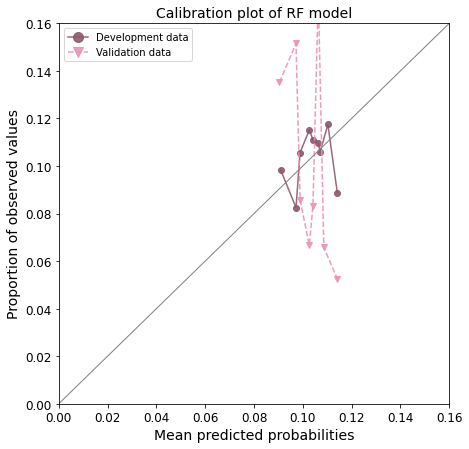

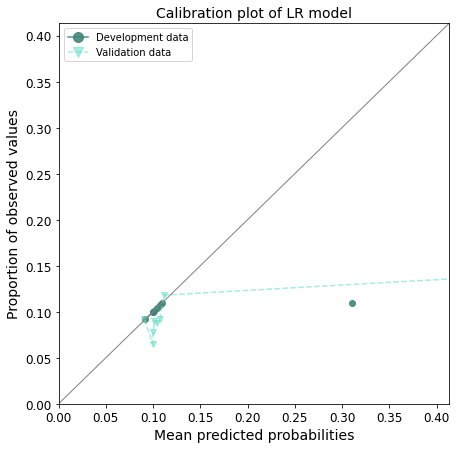

In [46]:
#build cox model for hosp prediction using non ab users' data
prob_pred_lrti_no_abs_prevl_during_pandemic, prob_pred_lrti_no_abs_prevl_during_pandemic_bin = cox_build('lrti', 'prevl_during_pandemic', data_lrti_prevl_during_pandemic, data_lrti_no_abs_prevl_during_pandemic)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_during_pandemic, data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic = lr_rf_build_risk_deciles('lrti', 'prevl_during_pandemic_deciles', prob_pred_lrti_no_abs_prevl_during_pandemic)

#calibration plots of rf and lr
calibration_rf_lr('lrti', 'prevl_during_pandemic', data_enc_dev_prevl_during_pandemic, data_enc_val_prevl_during_pandemic, lr_pred_dev_prevl_during_pandemic, lr_pred_val_prevl_during_pandemic, rf_pred_dev_prevl_during_pandemic, rf_pred_val_prevl_during_pandemic)

<lifelines.CoxPHFitter: fitted with 5342 total observations, 5302 right-censored observations>
             duration col = 'duration_lrti_admitted'
                event col = 'event_lrti_admitted'
      baseline estimation = breslow
   number of observations = 5342
number of events observed = 40
   partial log-likelihood = -317.11
         time fit was run = 2023-07-10 18:29:19 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
CCI_cat[T.low]                  -0.44       0.64       0.50            -1.42             0.53                 0.24                 1.70
CCI_cat[T.medium]                0.08       1.08       0.50            -0.90             1.06                 0.41                 2.89
CCI_cat[T.high]                 -0.41       0.66       0.69            -1.77             0.95                 0.17                 2.58
CCI_cat[T.very_high]             0.39       1.48       0.50            -0.58             1.37                 0.56                 3.95
age_cat[T.25_34]                 1.05       2.86       0.60            -0.12             2.22                 0.88                 9.24
age_cat[T.35_44]                 1.02       2.77       0.60            -0.15             2.19                 0.86                 8.95
age_cat[T.45_54]                -0.16       0.85       0.77            -1.67             1.34                 0.19                 3.83
age_cat[T.55_64]                -1.24       0.29       1.12            -3.44             0.96                 0.03                 2.61
age_cat[T.65_74]                 0.51       1.66       0.65            -0.77             1.78                 0.46                 5.95
age_cat[T.75_more]               0.46       1.59       0.65            -0.81             1.74                 0.44                 5.70
antibacterial_brit               0.05       1.05       0.11            -0.17             0.27                 0.85                 1.31
bmi_cat[T.obese]                 0.11       1.12       0.76            -1.37             1.60                 0.25                 4.94
bmi_cat[T.overweight]            0.93       2.52       0.80            -0.63             2.48                 0.53                11.99
bmi_cat[T.underweight]           2.05       7.76       0.83             0.42             3.67                 1.53                39.34
bmi_cat[T.unknown]               0.39       1.48       0.79            -1.15             1.93                 0.32                 6.90
ethnicity[T.other]               0.02       1.02       0.72            -1.39             1.43                 0.25                 4.20
ethnicity[T.unknown]            -0.08       0.92       0.60            -1.26             1.09                 0.28                 2.99
ethnicity[T.white]              -0.23       0.79       0.55            -1.31             0.85                 0.27                 2.34
flu_vaccine[T.yes]              -1.40       0.25       1.02            -3.39             0.60                 0.03                 1.81
imd[T.medium]                   -0.17       0.84       0.61            -1.37             1.02                 0.25                 2.78
imd[T.unaffluent]                0.36       1.44       0.53            -0.68             1.40                 0.51                 4.07
imd[T.unknown]                   0.41       1.51       0.82            -1.20             2.03                 0.30                 7.59
imd[T.very_affluent]             0.45       1.56       0.53            -0.59             1.49                 0.55                 4.42
imd[T.very_unaffluent]           0.36       1.43       0.53            -0.68             1.40                 0.51                 4.07
region[T.east_midlands]         -0.31       0.73       0.59            -1

13041


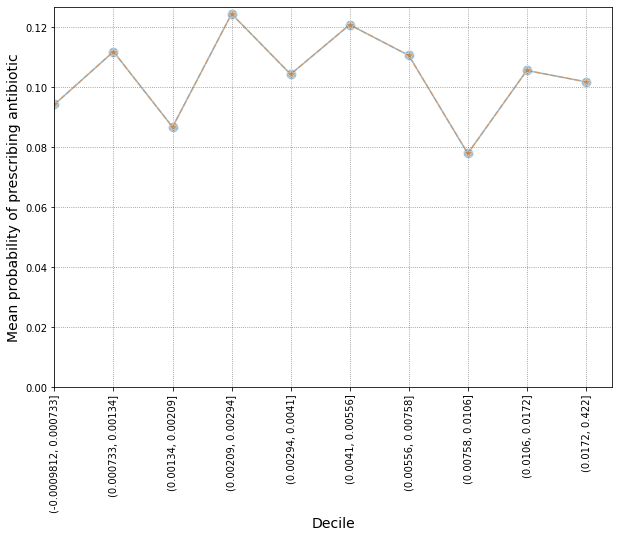


AUROC of LR for deciles with development and validation data: 0.51616 and 0.55912
AUROC of RF for deciles with development and validation data: 0.53452 and 0.55407
LR coefficients:
                                 OR  Lower CI  Upper CI
bins_(0.000733, 0.00134]  0.119403  0.092139  0.154735
bins_(0.00134, 0.00209]   0.100186  0.075737  0.132527
bins_(0.00209, 0.00294]   0.131238  0.102475  0.168076
bins_(0.00294, 0.0041]    0.113462  0.086679  0.148520
bins_(0.0041, 0.00556]    0.126654  0.098229  0.163305
bins_(0.00556, 0.00758]   0.117202  0.090089  0.152475
bins_(0.00758, 0.0106]    0.088929  0.066398  0.119107
bins_(0.0106, 0.0172]     0.126160  0.098034  0.162353
bins_(0.0172, 0.422]      0.112570  0.086201  0.147006

RF feature importance:
                            rf_coef
bins_(0.00209, 0.00294]   0.169966
bins_(0.00758, 0.0106]    0.160297
bins_(0.0041, 0.00556]    0.130380
bins_(0.0106, 0.0172]     0.119532
bins_(0.00134, 0.00209]   0.092883
bins_(0.000733, 0.00134]  0.0896

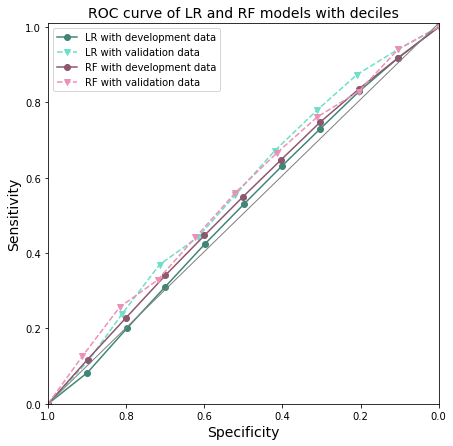

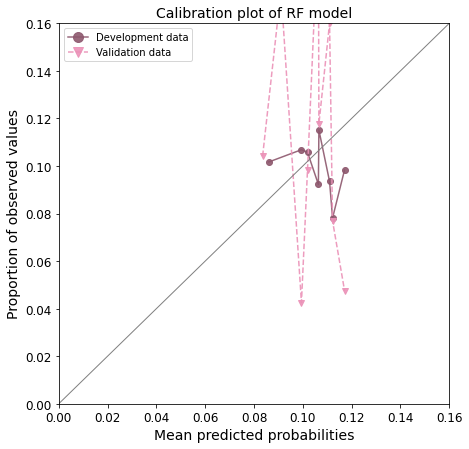

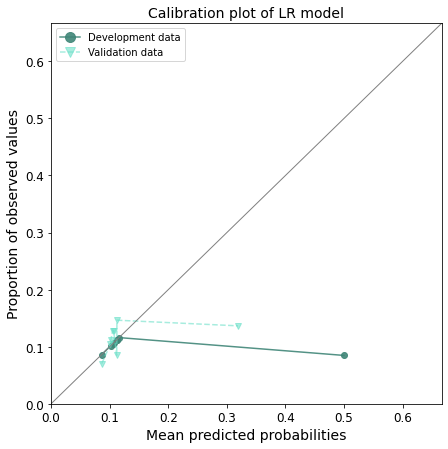

In [47]:
#build cox model for hosp prediction using non ab users' data
prob_pred_lrti_no_abs_prevl_post_2nd_lockdown, prob_pred_lrti_no_abs_prevl_post_2nd_lockdown_bin = cox_build('lrti', 'prevl_post_2nd_lockdown', data_lrti_prevl_post_2nd_lockdown, data_lrti_no_abs_prevl_post_2nd_lockdown)

#build rf and lr models
prob_pred_enc_lr_rf_prevl_post_2nd_lockdown, data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown = lr_rf_build_risk_deciles('lrti', 'prevl_post_2nd_lockdown_deciles', prob_pred_lrti_no_abs_prevl_post_2nd_lockdown)

#calibration plots of rf and lr
calibration_rf_lr('lrti', 'prevl_post_2nd_lockdown', data_enc_dev_prevl_post_2nd_lockdown, data_enc_val_prevl_post_2nd_lockdown, lr_pred_dev_prevl_post_2nd_lockdown, lr_pred_val_prevl_post_2nd_lockdown, rf_pred_dev_prevl_post_2nd_lockdown, rf_pred_val_prevl_post_2nd_lockdown)